<a href="https://colab.research.google.com/github/mileskarr/Final-Project/blob/main/Copy_of_Draft_Code_for_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sweetviz
!pip install vaderSentiment

#Imports
import pandas as pd
import numpy as np
import os
import glob
import nltk
import re
import string
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random
import collections
import statsmodels.api as sm
import scipy.stats as ss
import sweetviz as sv
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from string import punctuation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from collections import Counter
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.1 MB/s eta 0:00:00
Mounted at /content/drive


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
os.chdir("/content/drive/MyDrive/CIND820/Data/Reviews")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_file = pd.concat([pd.read_csv(f) for f in all_filenames])



In [3]:
# We can see here that there is a high volume of missing data
missing = []
unique = []
types = []
variables = []
count = []

for item in combined_file.columns:
    variables.append(item)
    missing.append(combined_file[item].isnull().sum())
    unique.append(combined_file[item].nunique())
    types.append(combined_file[item].dtypes)
    count.append(len(combined_file[item]))

output = pd.DataFrame({
    'variable': variables,
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing,

})
print("Df info : ")
output.sort_values("missing",ascending=False).reset_index(drop=True)


Df info : 


variable    dtype    count  unique  missing
0                helpfulness  float64  1094411    3767   561592
1               review_title   object  1094411  364105   310654
2                 hair_color   object  1094411       7   226768
3                  eye_color   object  1094411       6   209628
4                  skin_tone   object  1094411      14   170539
5             is_recommended  float64  1094411       2   167988
6                  skin_type   object  1094411       4   111557
7                review_text   object  1094411  969419     1444
8                 brand_name   object  1094411     142        0
9               product_name   object  1094411    2334        0
10                product_id   object  1094411    2351        0
11                Unnamed: 0    int64  1094411  602130        0
12                 author_id   object  1094411  578653        0
13           submission_time   object  1094411    5317        0
14  total_pos_feedback_count    int64  1094411     590        0
15  total_neg_feedback_count    int64  1094411     259        0
16      total_feedback_count    int64  1094411     676        0
17                    rating    int64  1094411       5        0
18                 price_usd  float64  1094411     221        0

In [4]:
#To view datatypes.
combined_file.dtypes

Unnamed: 0                    int64
author_id                    object
rating                        int64
is_recommended              float64
helpfulness                 float64
total_feedback_count          int64
total_neg_feedback_count      int64
total_pos_feedback_count      int64
submission_time              object
review_text                  object
review_title                 object
skin_tone                    object
eye_color                    object
skin_type                    object
hair_color                   object
product_id                   object
product_name                 object
brand_name                   object
price_usd                   float64
dtype: object

In [5]:
#Here we can see that the mean review rating given by a user is 4.3 and the median a 4. We should investigate whether the dataset is balanced.
combined_file.describe()

Unnamed: 0        rating  is_recommended    helpfulness  \
count  1.094411e+06  1.094411e+06   926423.000000  532819.000000   
mean   1.989864e+05  4.299158e+00        0.839962       0.767782   
std    1.749886e+05  1.149444e+00        0.366642       0.317164   
min    0.000000e+00  1.000000e+00        0.000000       0.000000   
25%    5.590600e+04  4.000000e+00        1.000000       0.652174   
50%    1.308240e+05  5.000000e+00        1.000000       0.928571   
75%    3.285265e+05  5.000000e+00        1.000000       1.000000   
max    6.021290e+05  5.000000e+00        1.000000       1.000000   

       total_feedback_count  total_neg_feedback_count  \
count          1.094411e+06              1.094411e+06   
mean           4.177126e+00              8.948695e-01   
std            2.271524e+01              5.288943e+00   
min            0.000000e+00              0.000000e+00   
25%            0.000000e+00              0.000000e+00   
50%            0.000000e+00              0.000000e+00   
75%            3.000000e+00              1.000000e+00   
max            5.464000e+03              1.159000e+03   

       total_pos_feedback_count     price_usd  
count              1.094411e+06  1.094411e+06  
mean               3.282257e+00  4.900838e+01  
std                1.967482e+01  4.004338e+01  
min                0.000000e+00  3.000000e+00  
25%                0.000000e+00  2.500000e+01  
50%                0.000000e+00  3.900000e+01  
75%                3.000000e+00  6.200000e+01  
max                5.050000e+03  1.900000e+03

In [6]:
#Here we can see a 5 and 4 star reviews making up the majority of rating indicating the dataset is imbalanced.
print (combined_file['rating'].value_counts())

5    698951
4    199389
3     81816
1     61223
2     53032
Name: rating, dtype: int64


In [7]:
#Changing data type of author_id for compatibility with report generator
combined_file['author_id'] = combined_file['author_id'].astype(str)

In [8]:
#Generate exploratory data analysis report
report = sv.analyze(combined_file)

                                             |          | [  0%]   00:00 -> (? left)


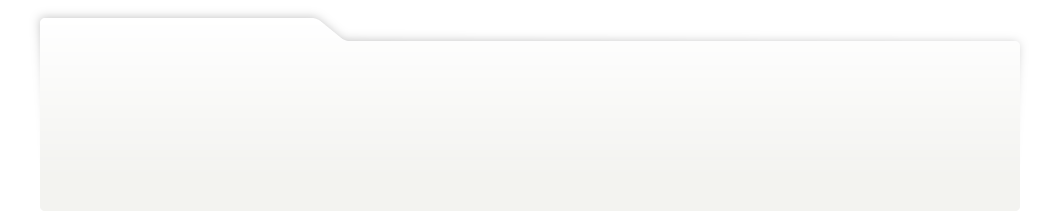
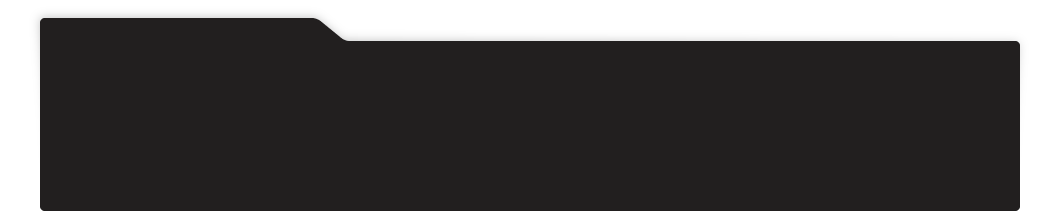
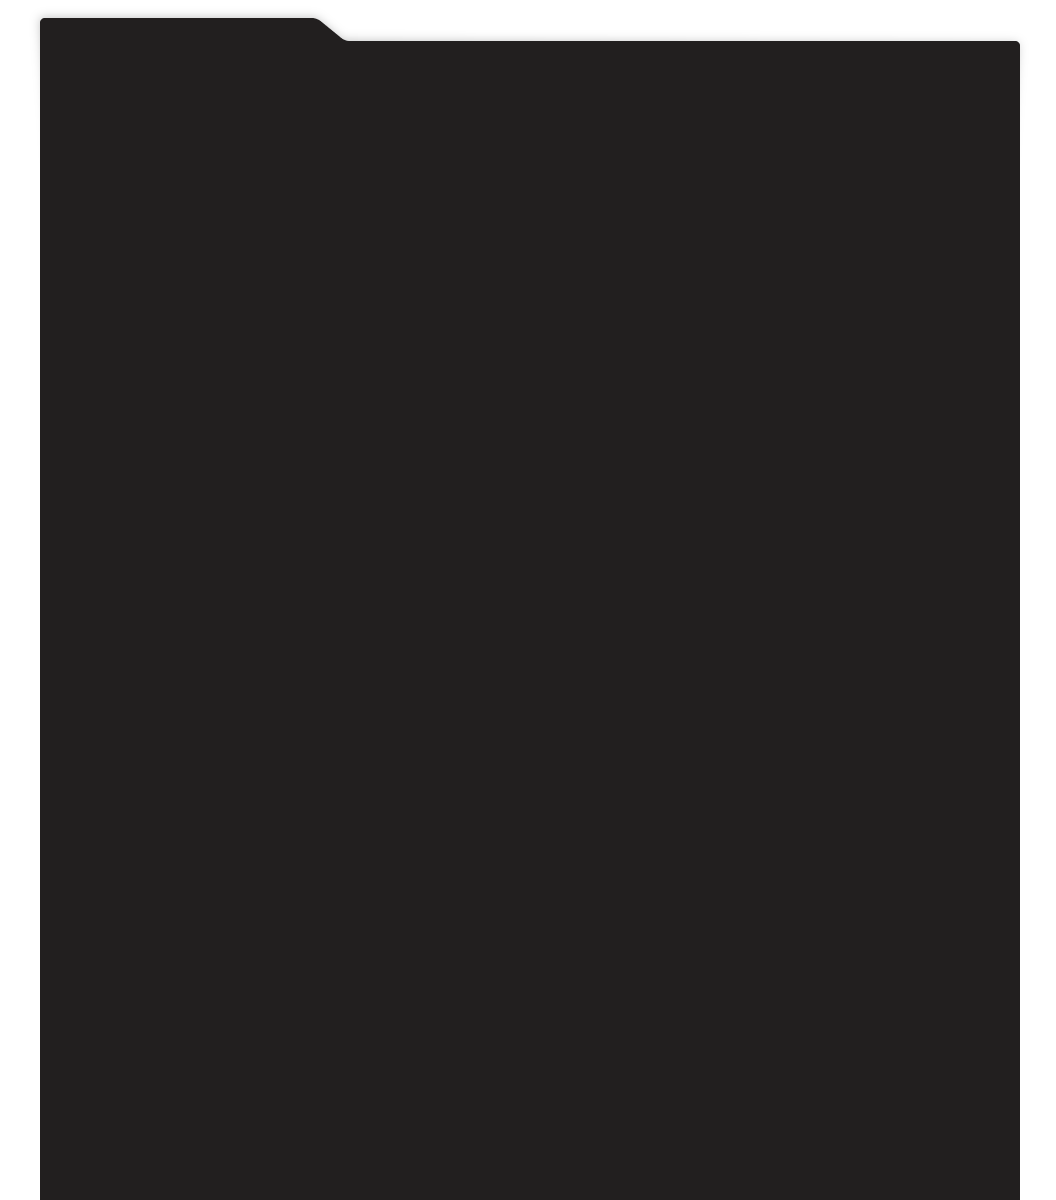
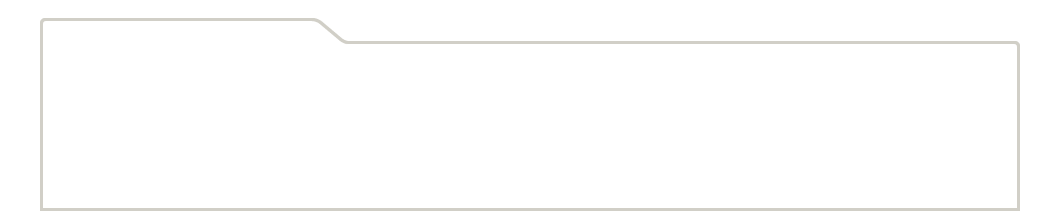
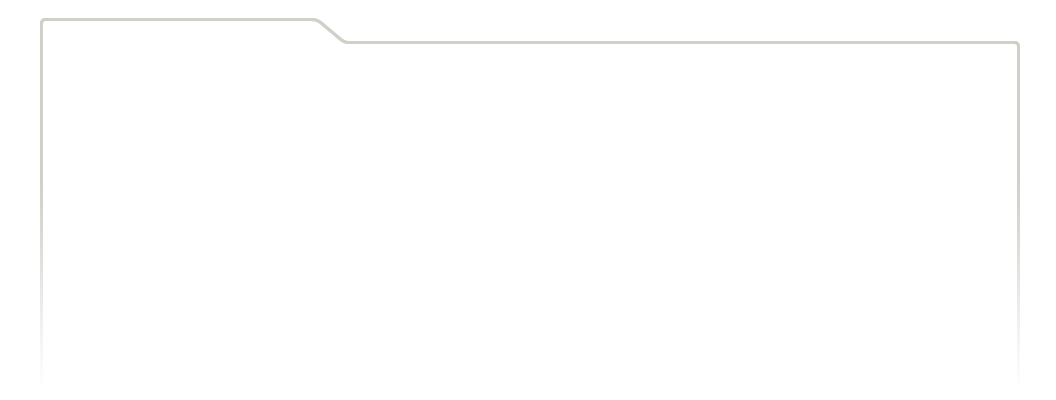
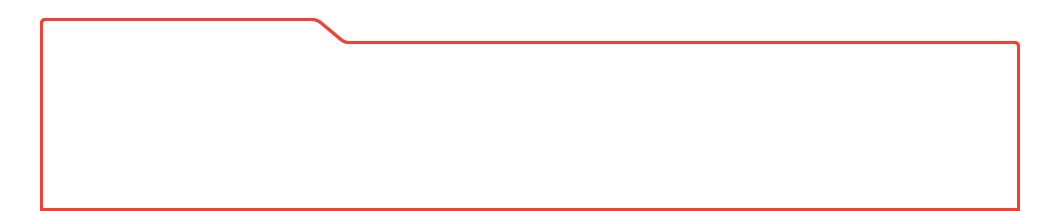
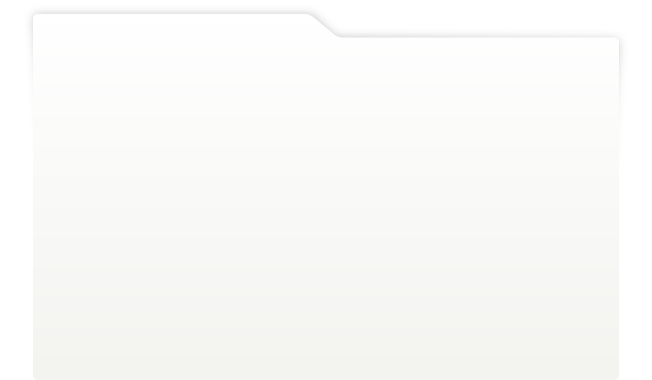
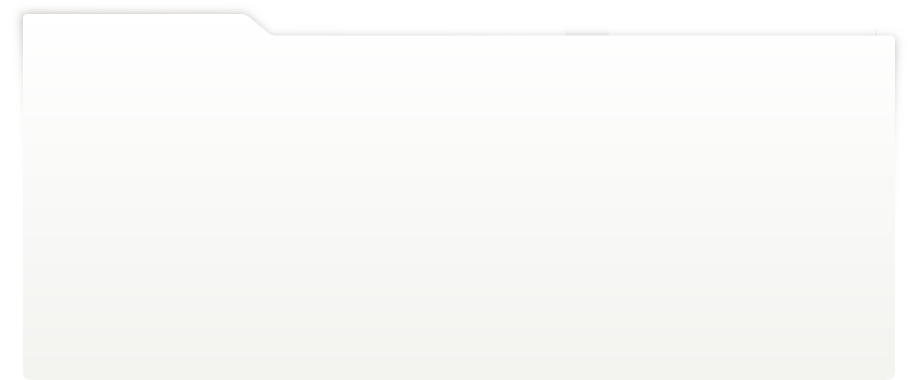
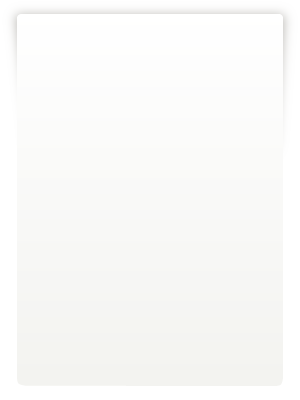
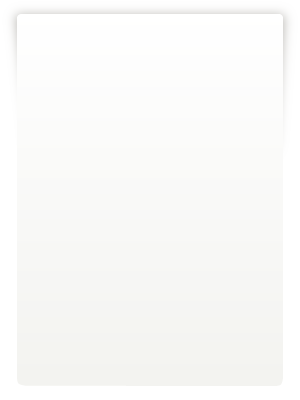
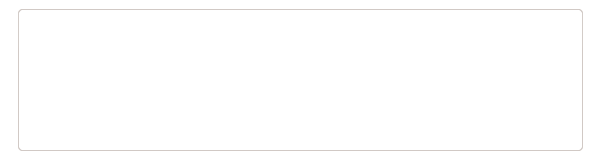
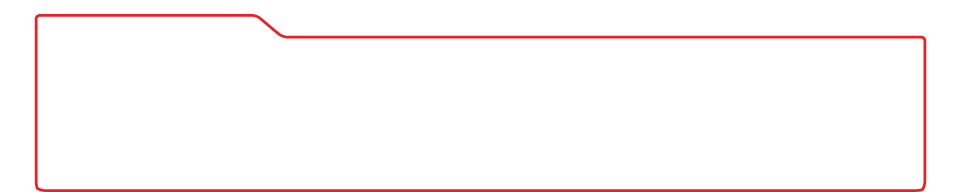
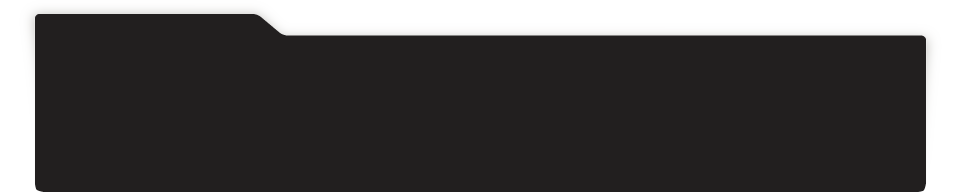
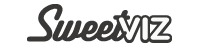
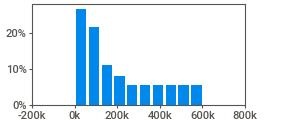
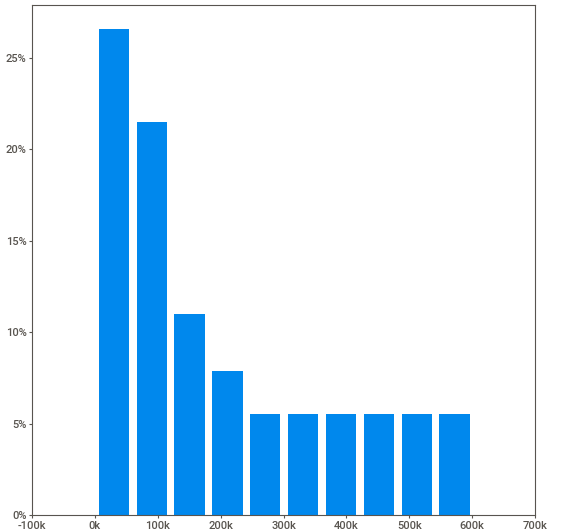
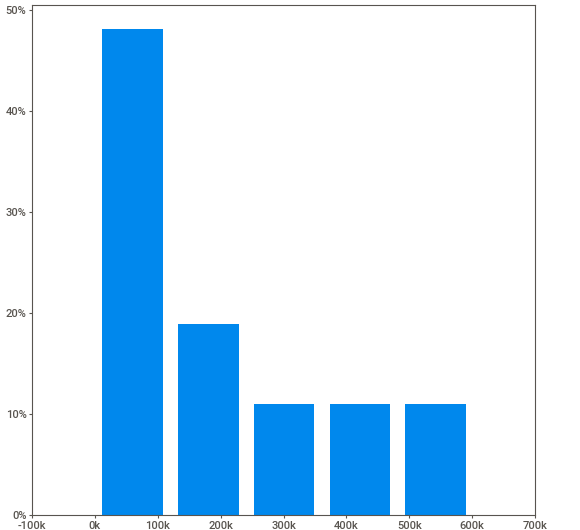
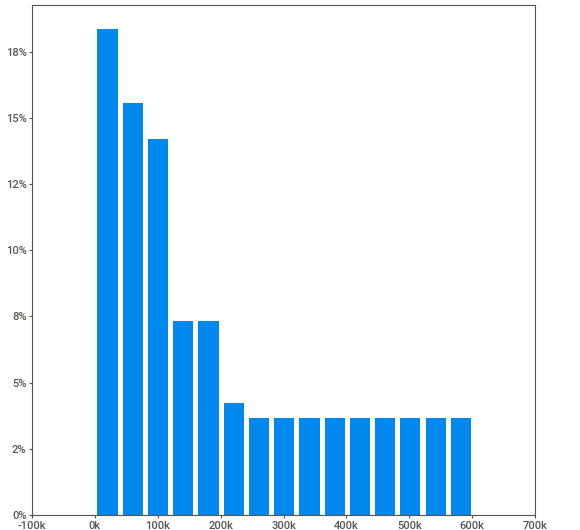
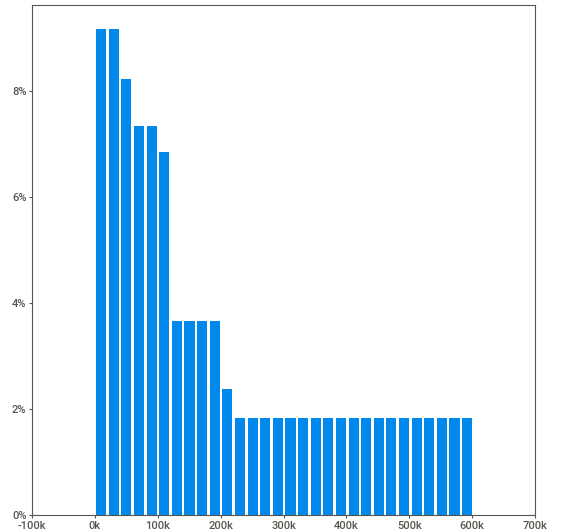
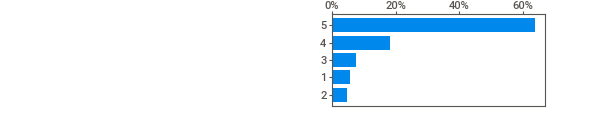
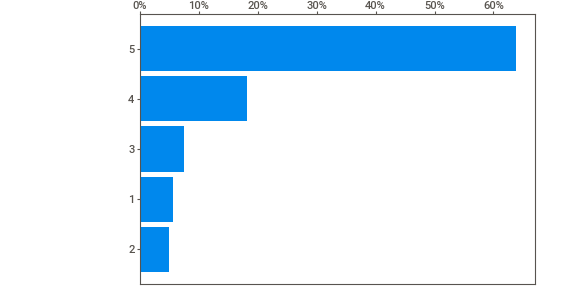
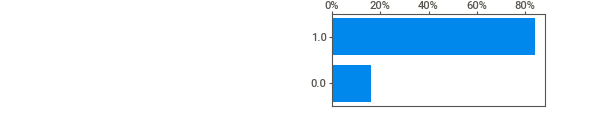
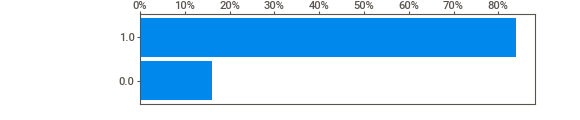
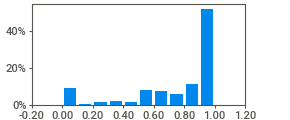
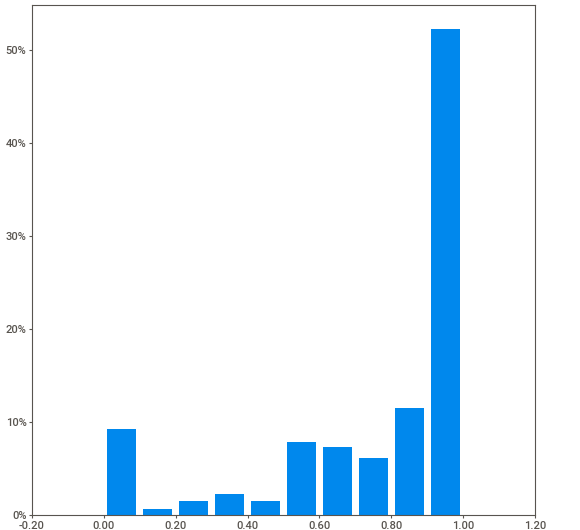
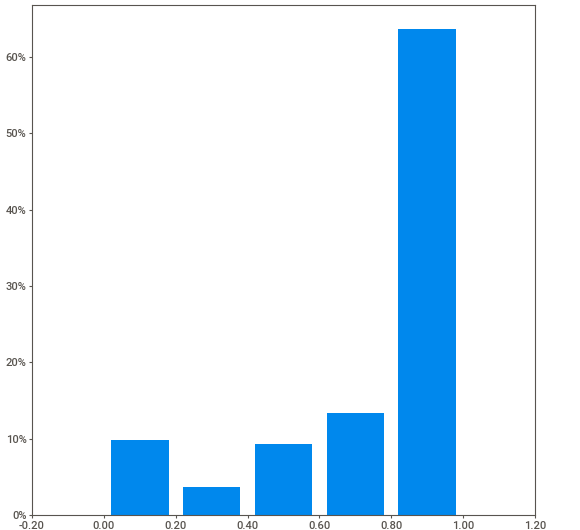
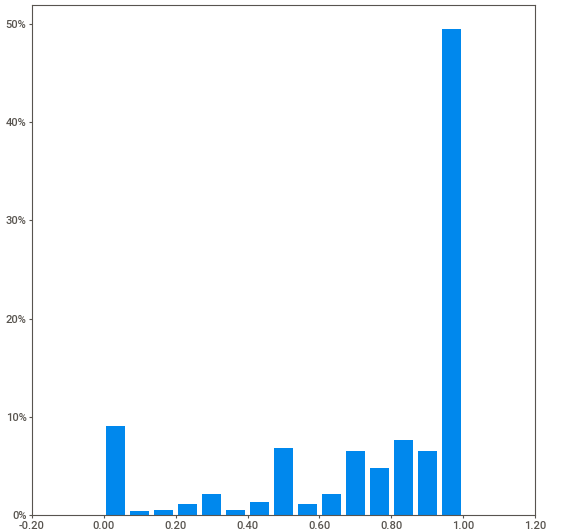
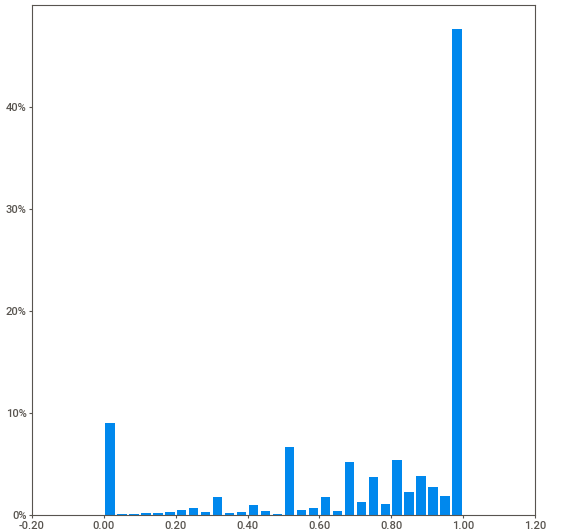
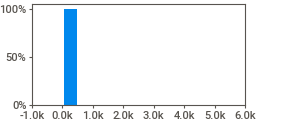
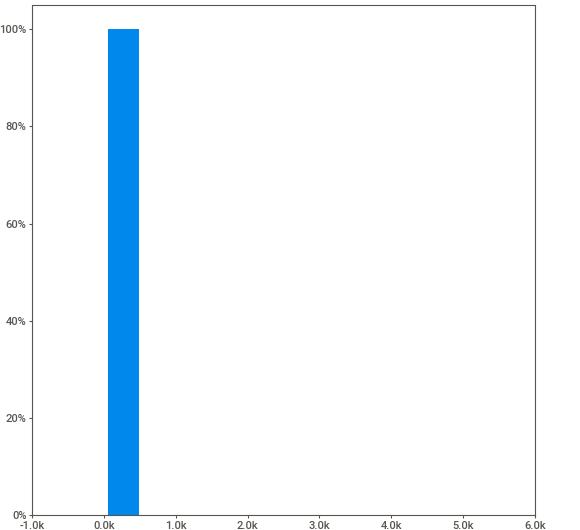
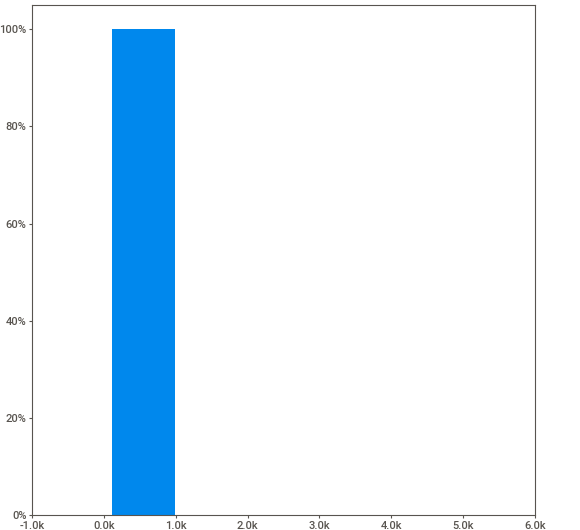
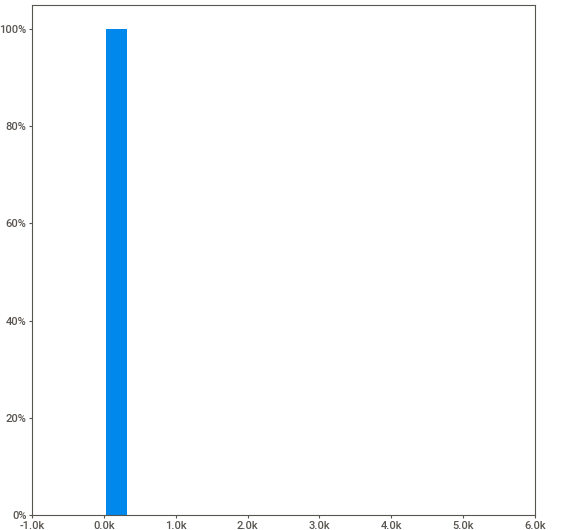
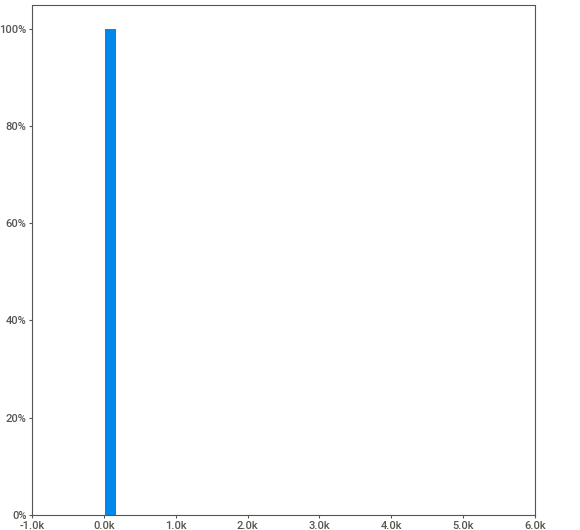
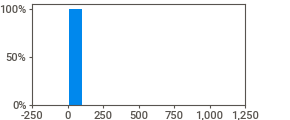
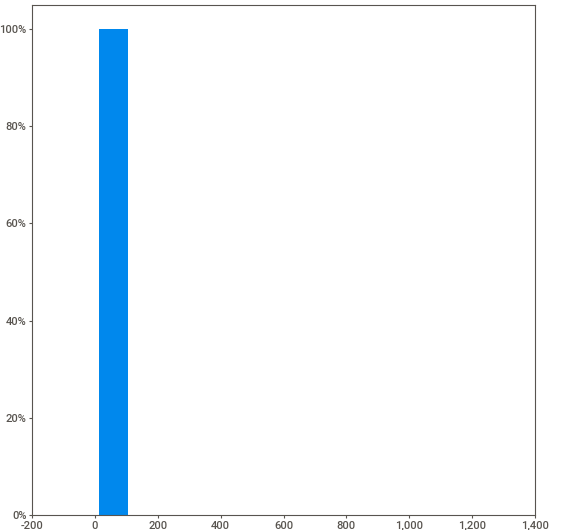
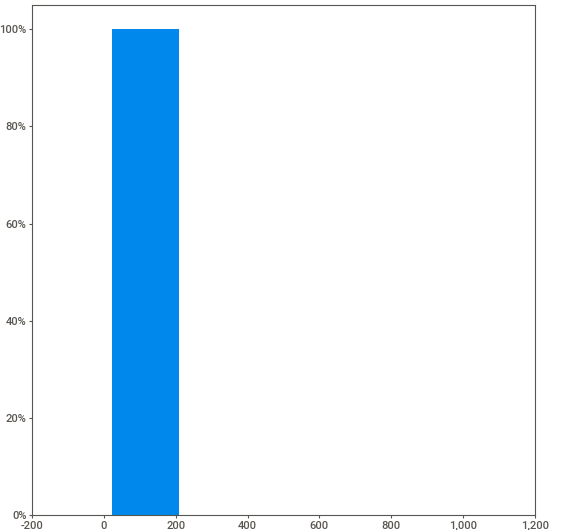
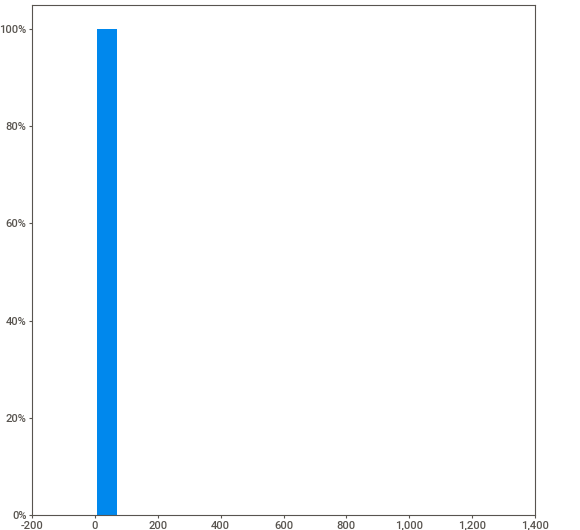
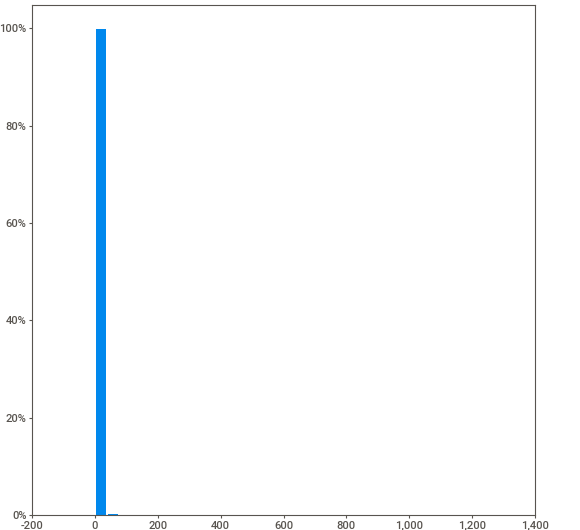
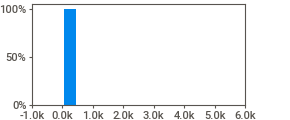
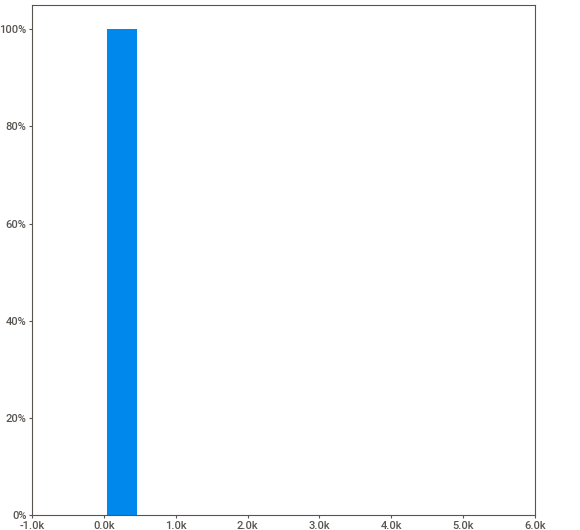
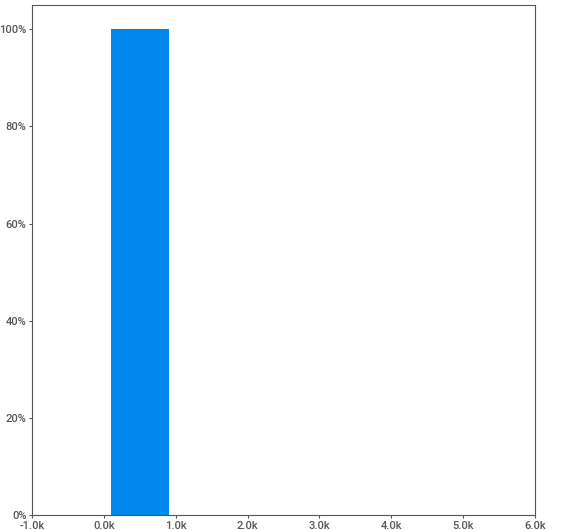
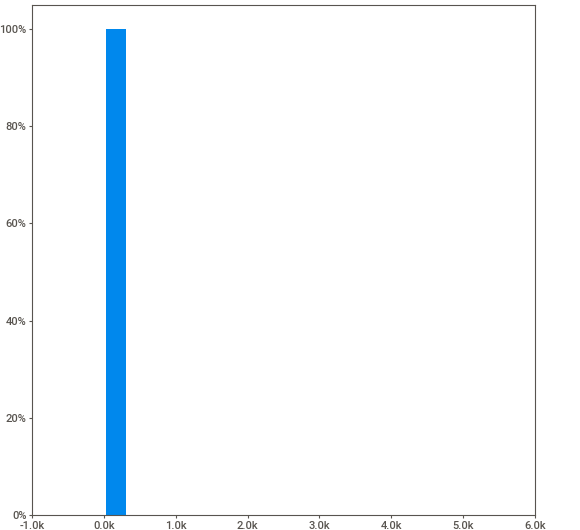
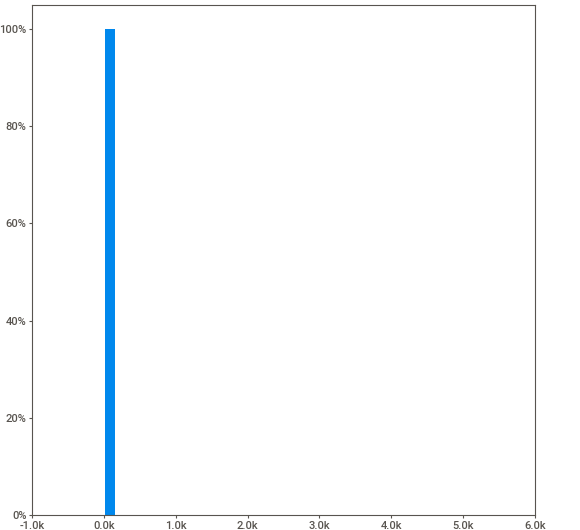
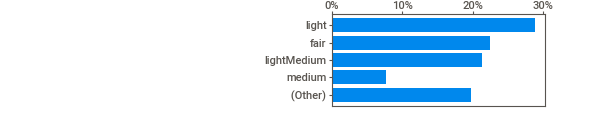
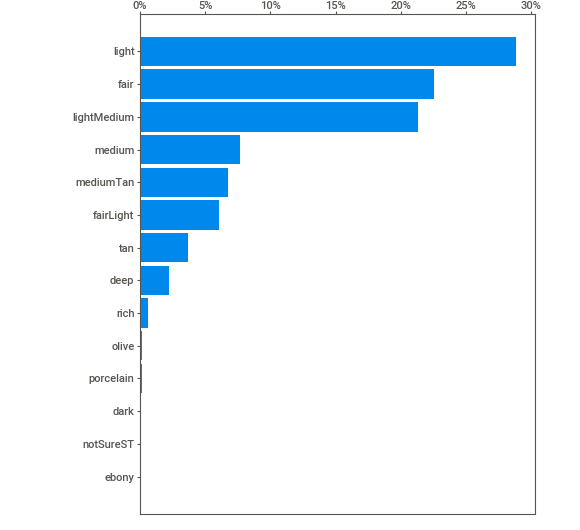
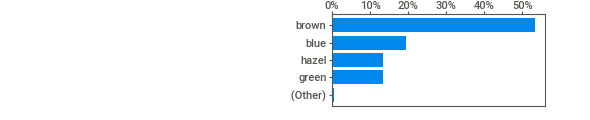
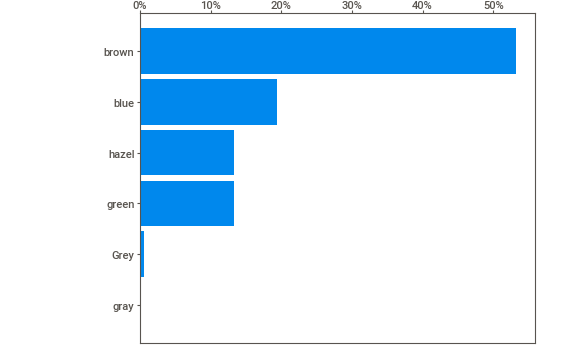
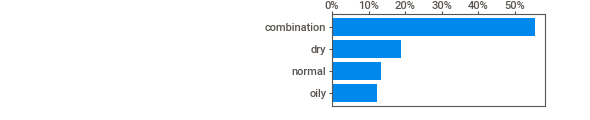
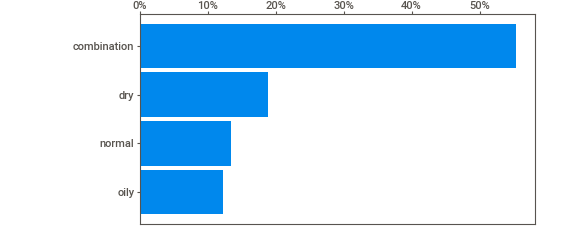
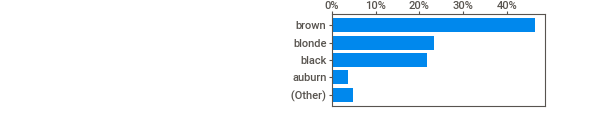
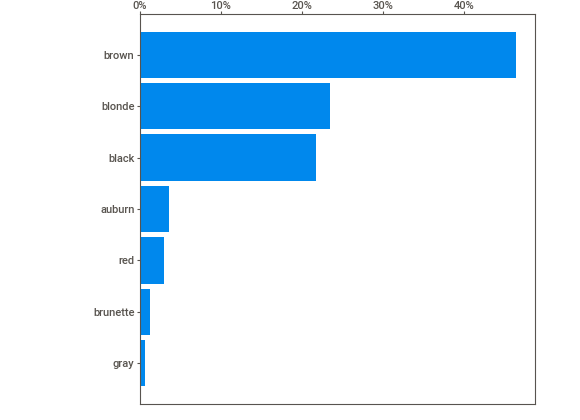
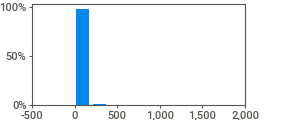
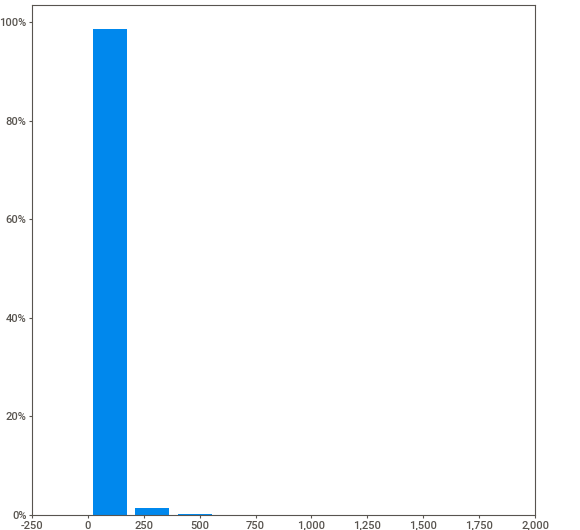
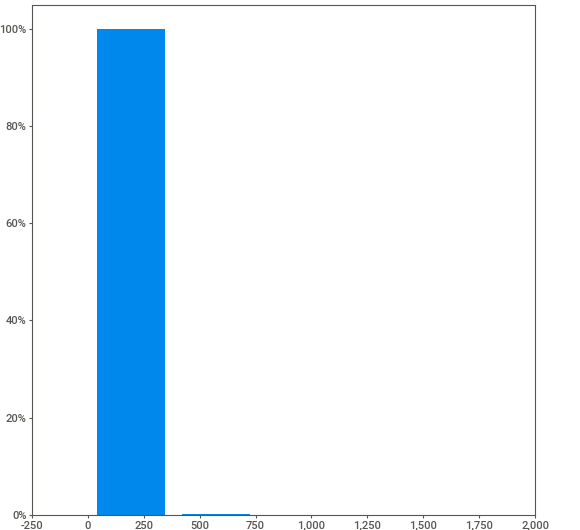
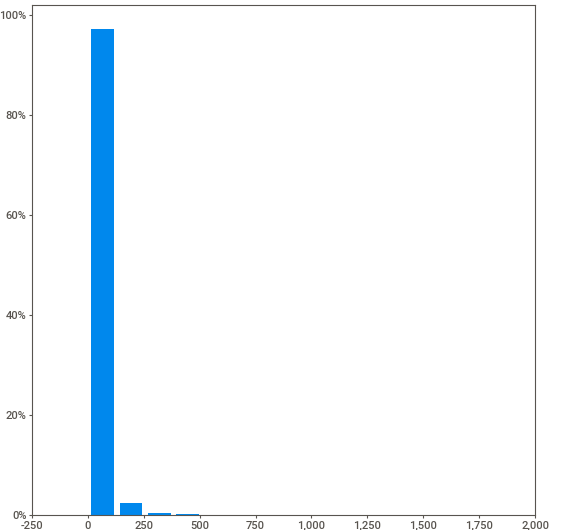
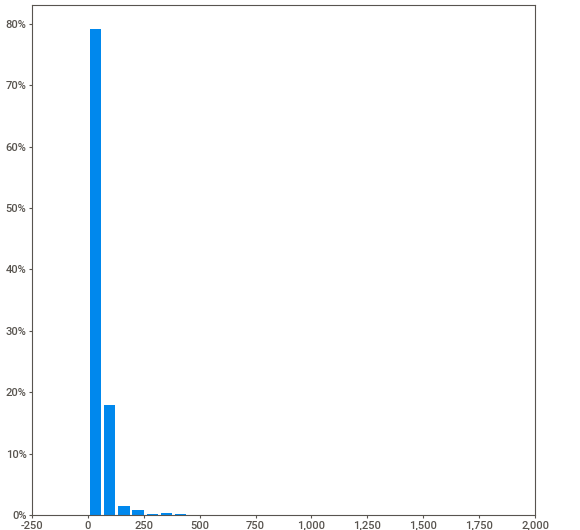
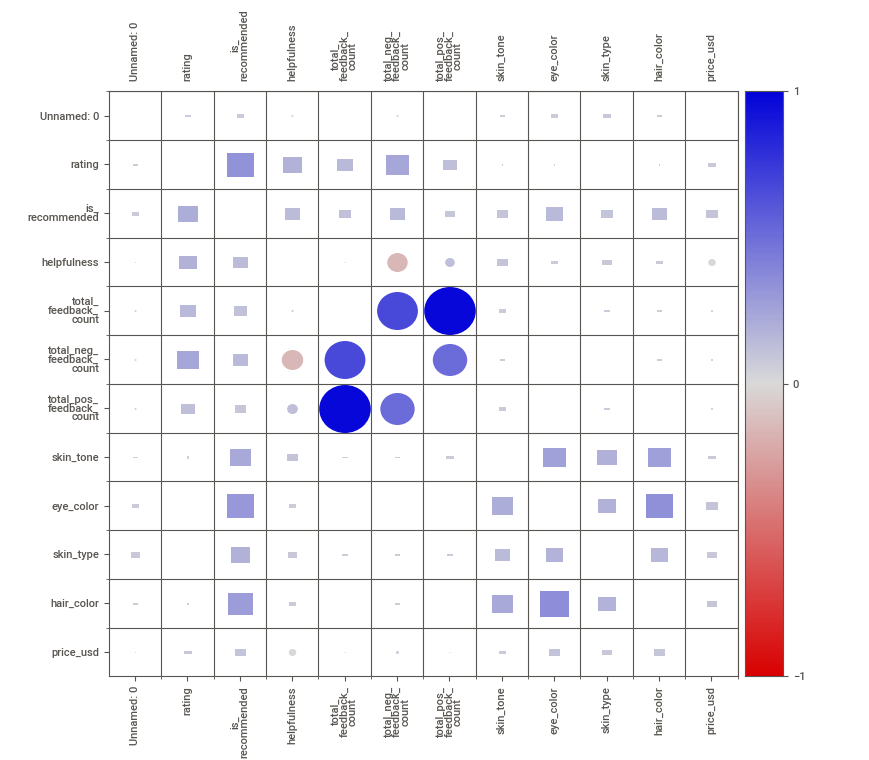
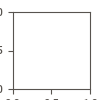

In [9]:
report.show_notebook()

<Axes: xlabel='is_recommended', ylabel='product_name'>

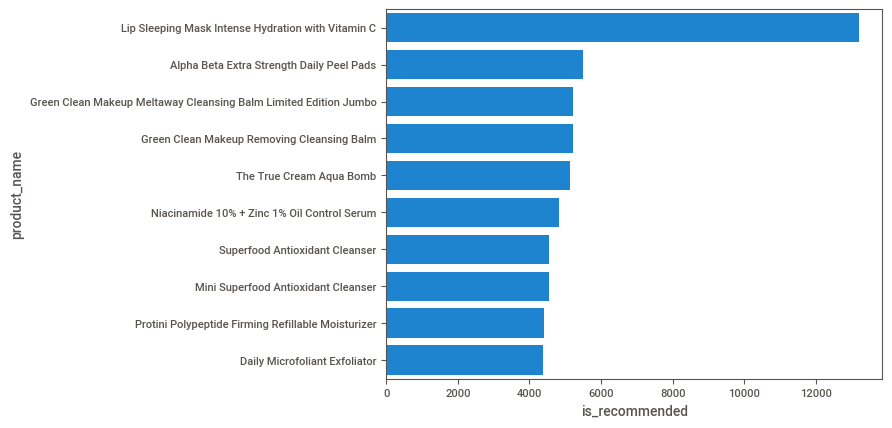

In [10]:
#Find the top 10 most reccommeded products
most_reccomended = combined_file.groupby(['product_id','product_name','brand_name']).sum(numeric_only=True)['is_recommended'].reset_index()\
.sort_values('is_recommended',ascending=False).head(10)
sns.barplot(most_reccomended,x='is_recommended',y='product_name')



In [11]:
#Get frequency of skin type
combined_file['skin_type'].value_counts()

combination    544513
dry            185937
normal         131910
oily           120494
Name: skin_type, dtype: int64

In [12]:
#Drop records with any missing values
df = combined_file.dropna(how='any')

In [13]:
#The only reason for sampling the dataset is that is is too large to work with on the platform and machine I am using. I've selected 100,000 samples
df = df.sample(n=100000)
#Checking rating distribution after removing NAs, we can see 5 star ratings are still significantly higher.
count = df['rating'].value_counts()
print (count)




5    59490
4    13877
1    10416
3     8859
2     7358
Name: rating, dtype: int64


In [14]:
#Using VADER to get sentiment scores for review_text
sid = SentimentIntensityAnalyzer()
df['Sentiment Scores'] = df['review_text'].apply(lambda skincare_overview: sid.polarity_scores(str(skincare_overview)))

In [15]:
df['compound'] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['compound'])
df["Negative_Score"] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['neg'])
df["Neutral_Score"] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['neu'])
df["Positive_Score"] = df['Sentiment Scores'].apply(lambda score_dict: score_dict['pos'])



In [16]:
#Using VADER to get sentiment scores for review_title
df['Sentiment Scores 2'] = df['review_title'].apply(lambda skincare_overview2: sid.polarity_scores(str(skincare_overview2)))

df['Compound_title'] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['compound'])
df["Negative_Score_Title"] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['neg'])
df["Neutral_Score_Title"] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['neu'])
df["Positive_Score_Title"] = df['Sentiment Scores 2'].apply(lambda score_dict: score_dict['pos'])




In [17]:
df = df.drop(columns=['Sentiment Scores', 'Sentiment Scores 2'], axis=1)

                                             |          | [  0%]   00:00 -> (? left)


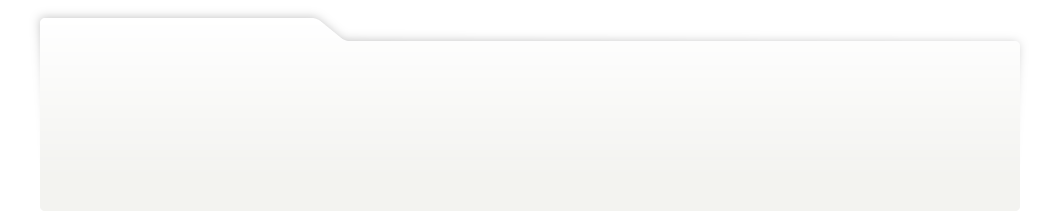
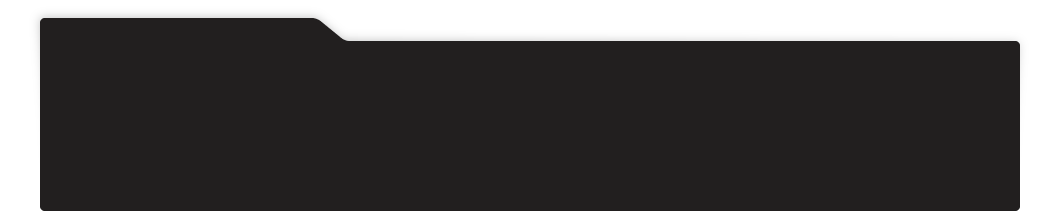
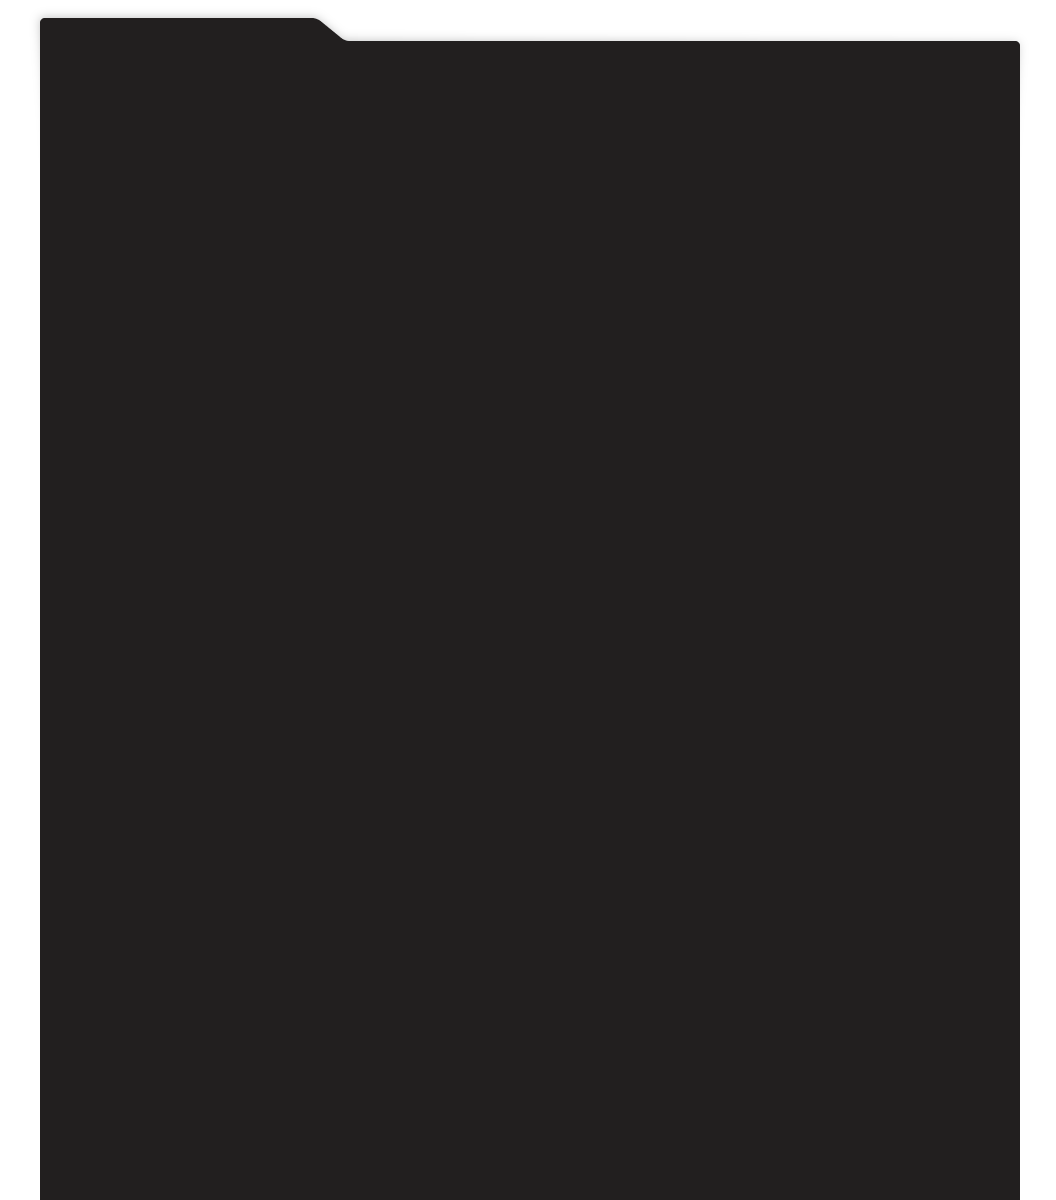
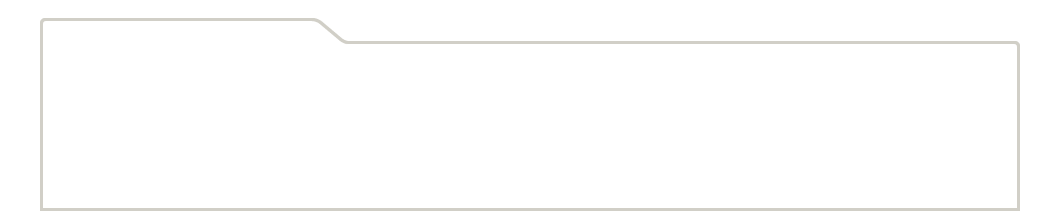
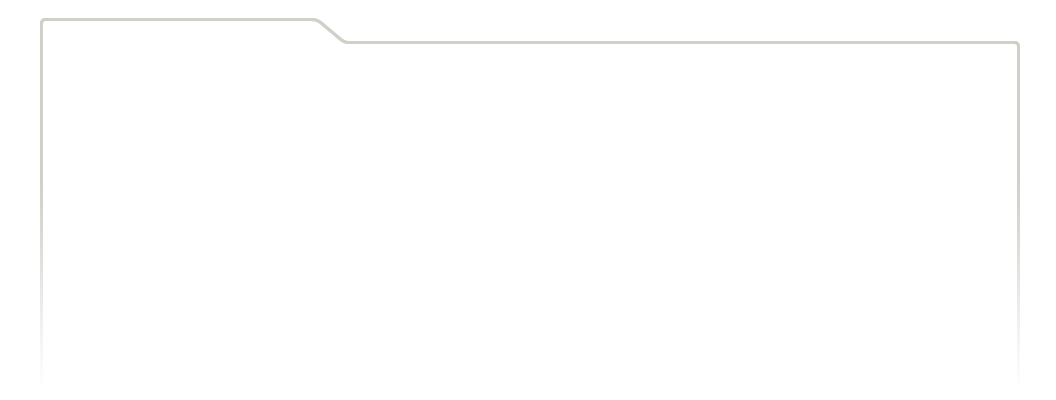
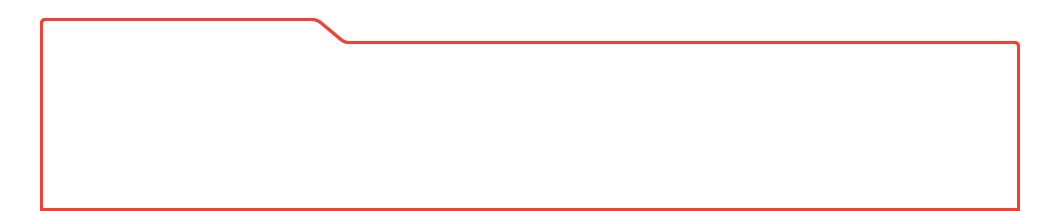
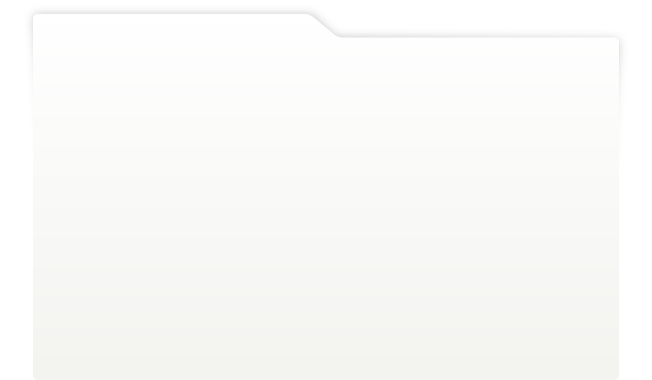
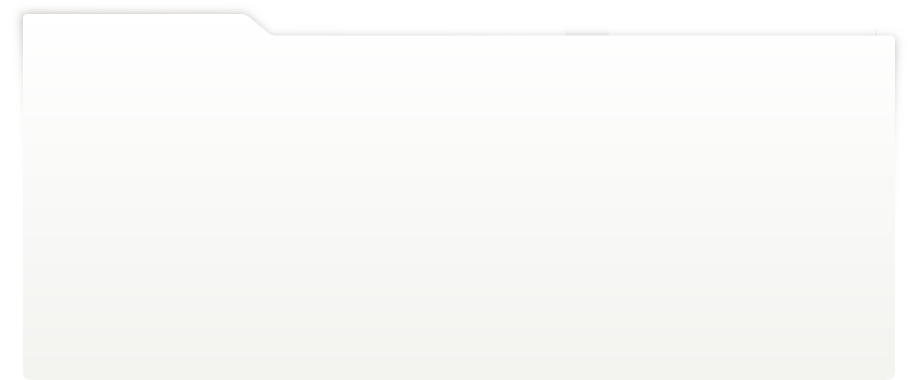
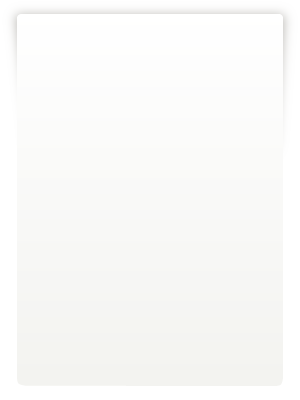
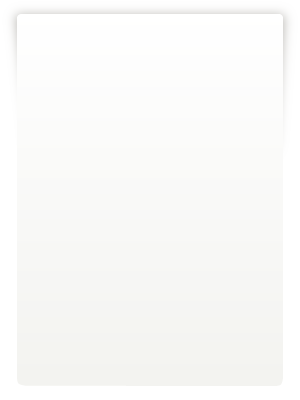
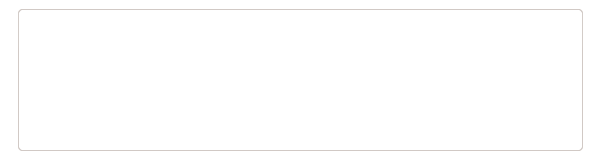
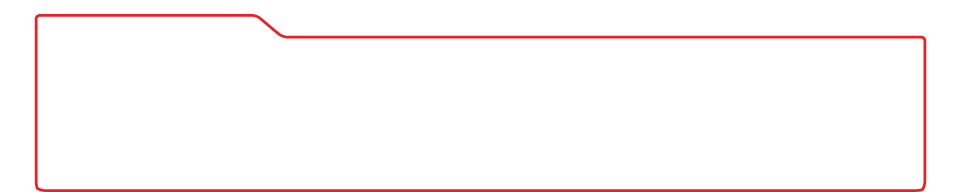
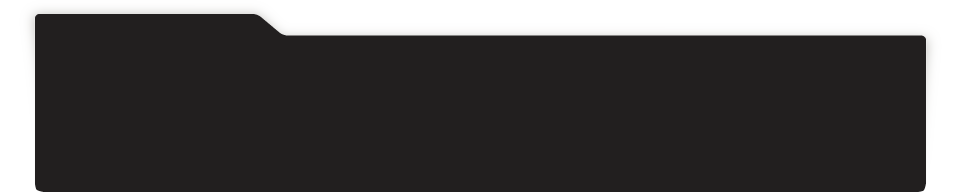
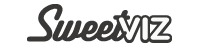
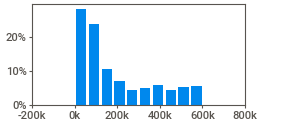
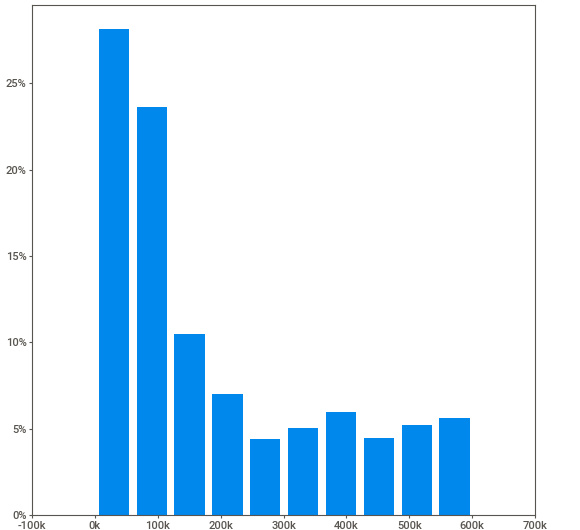
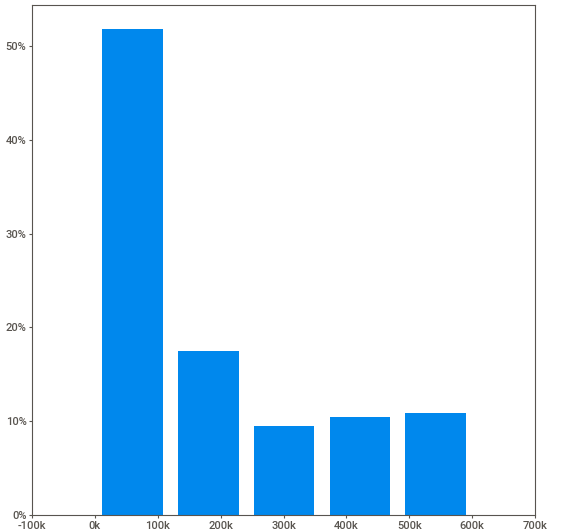
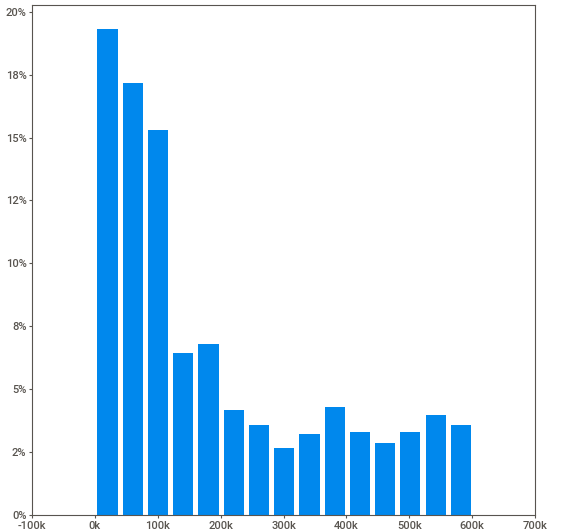
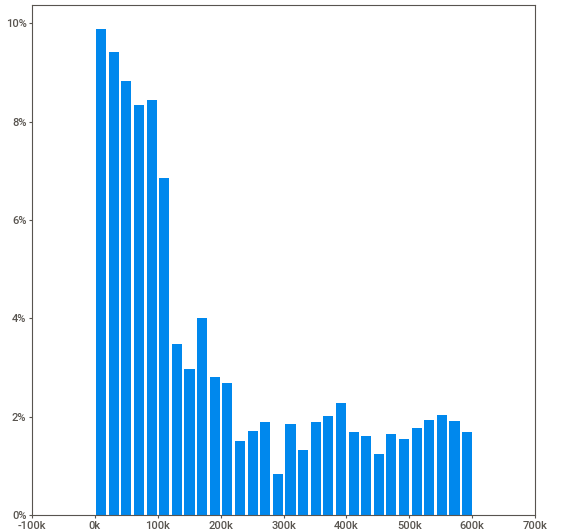
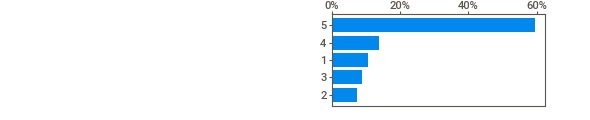
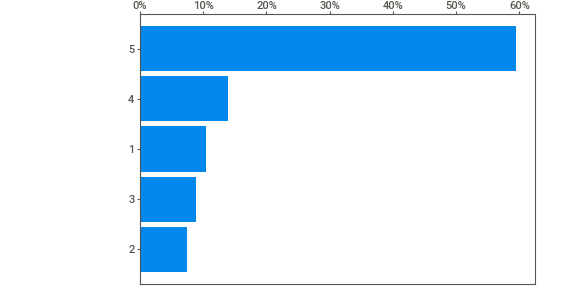
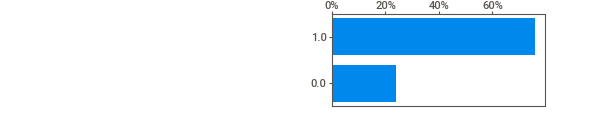
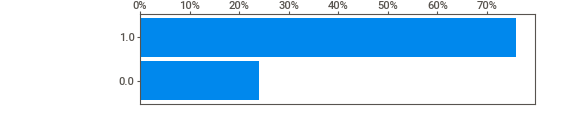
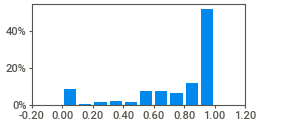
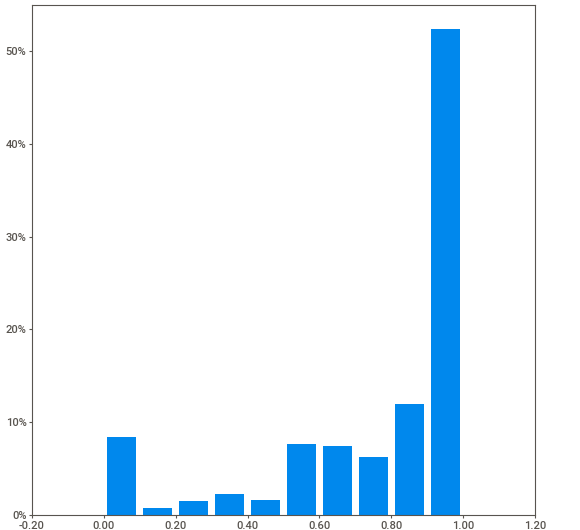
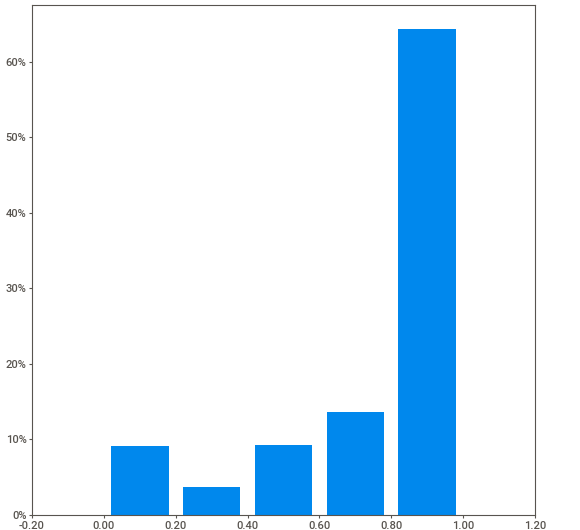
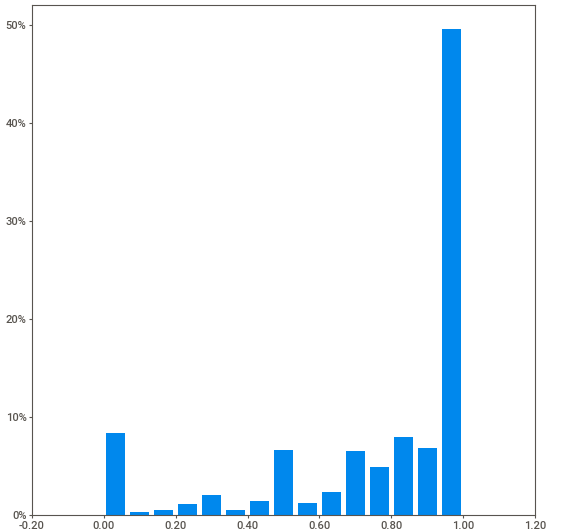
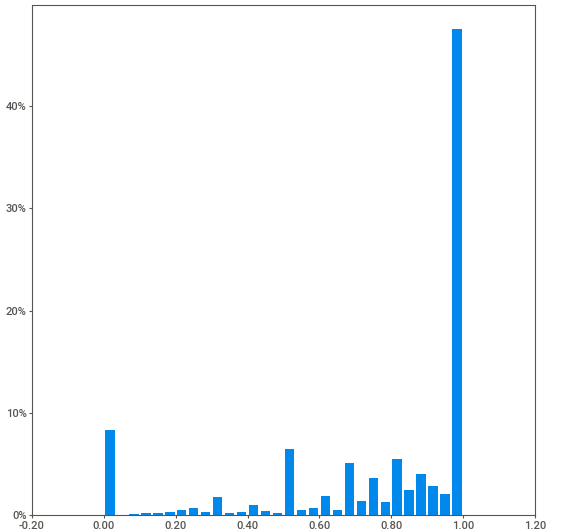
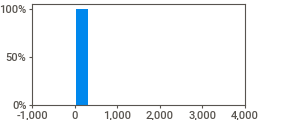
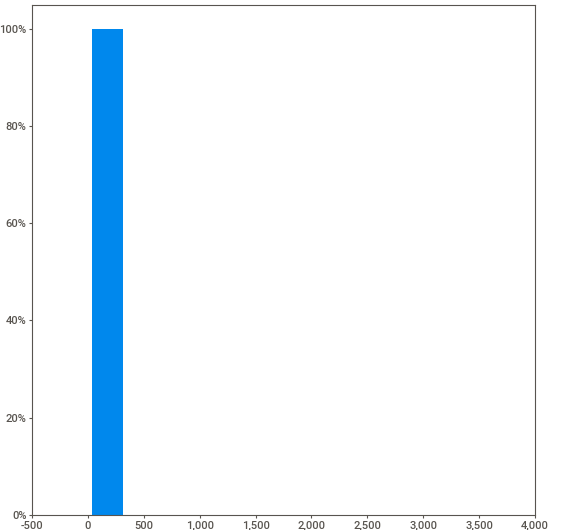
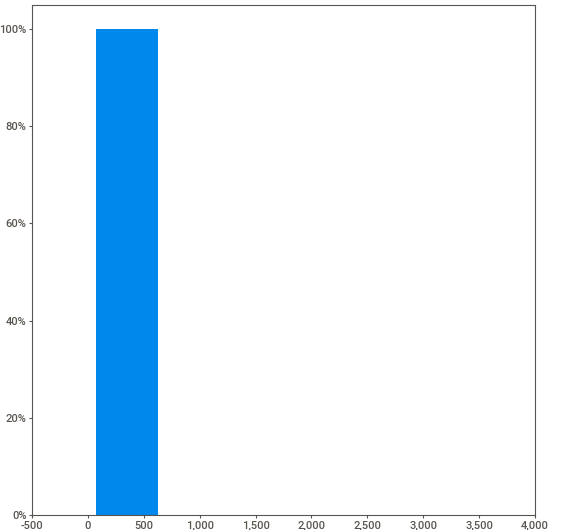
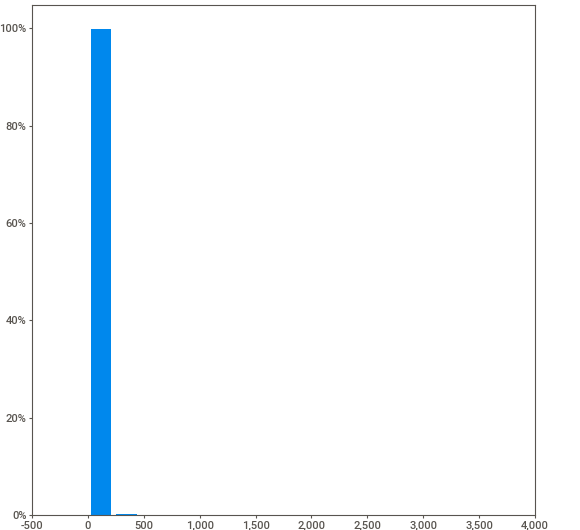
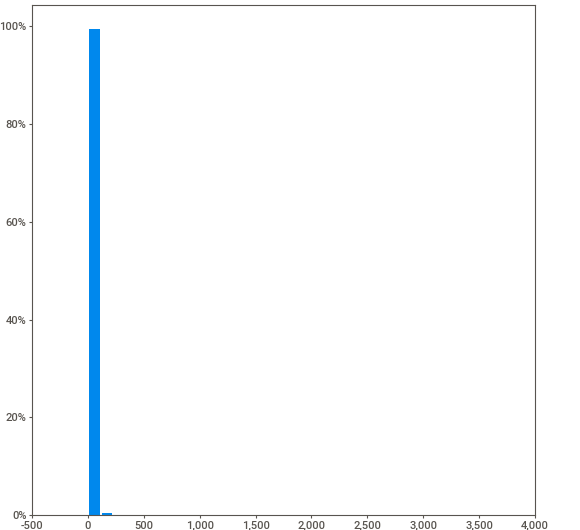
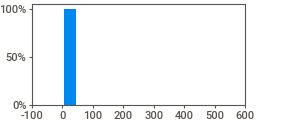
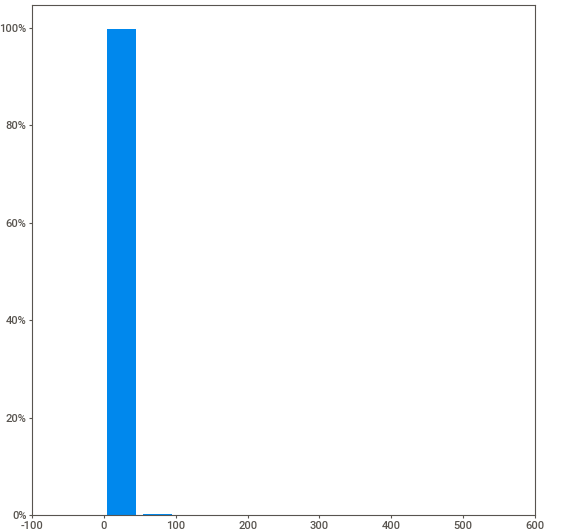
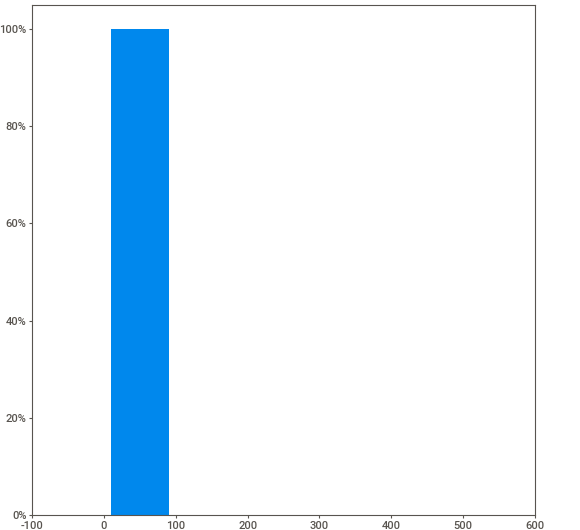
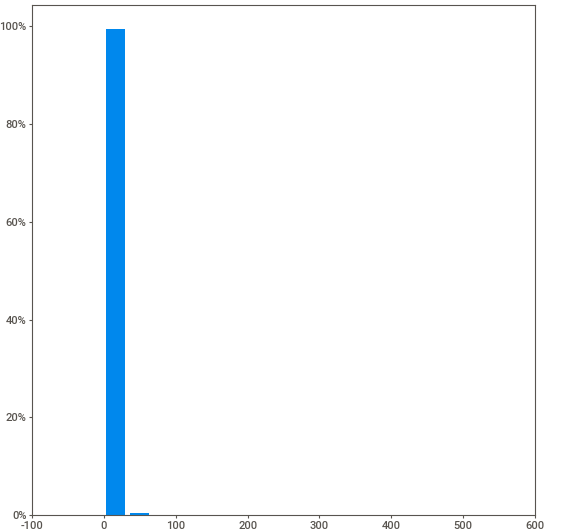
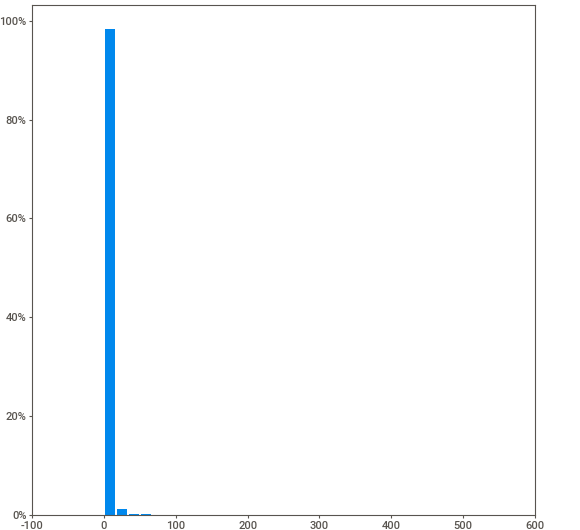
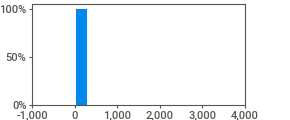
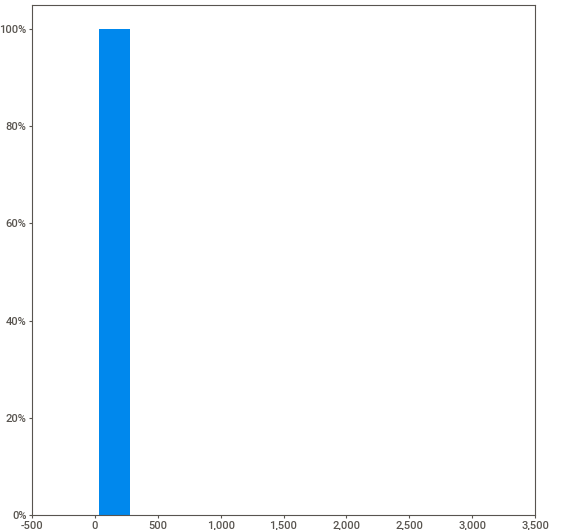
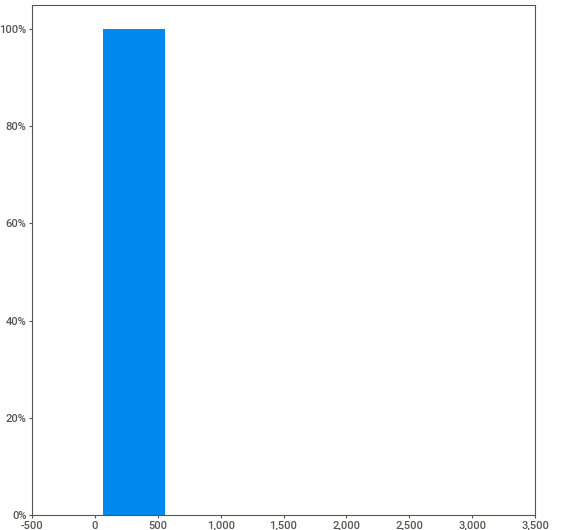
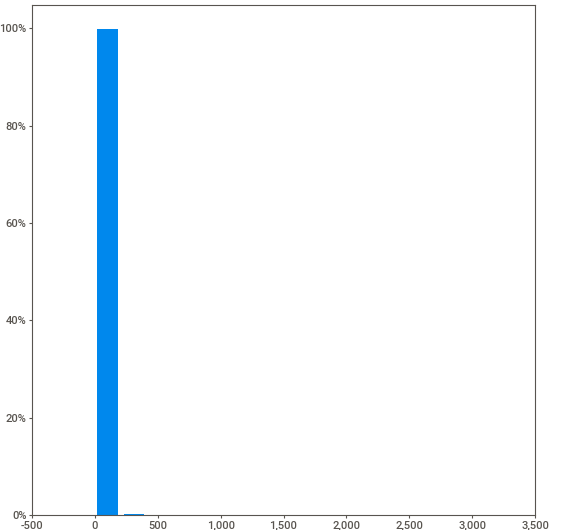
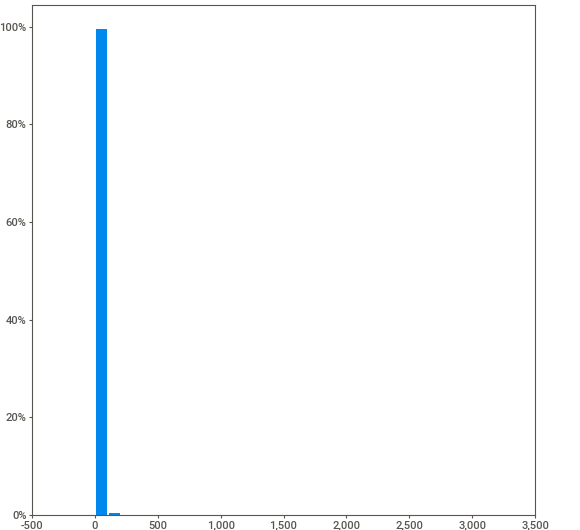
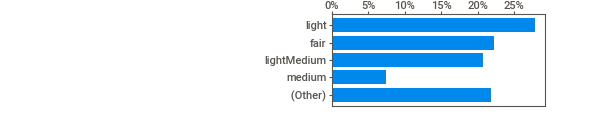
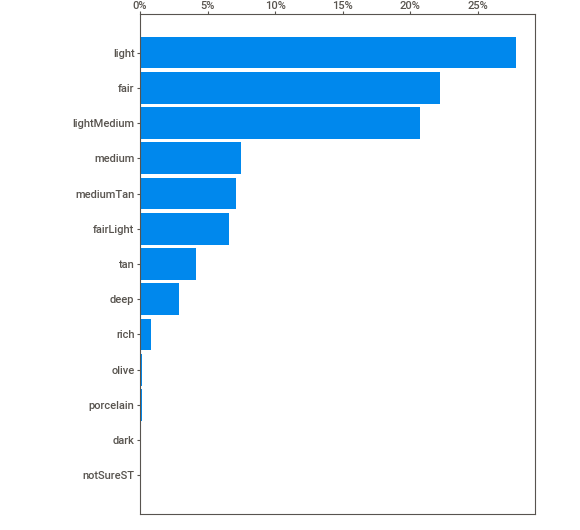
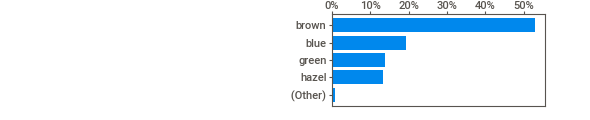
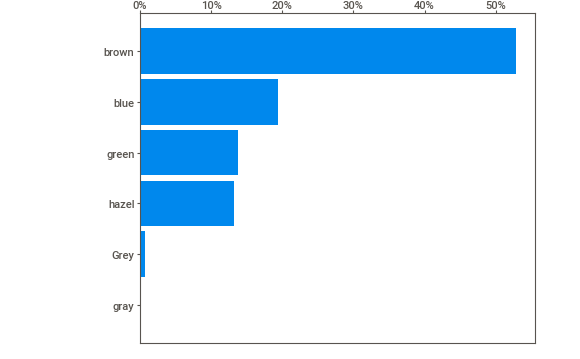
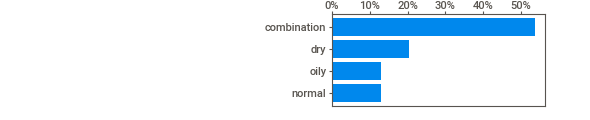
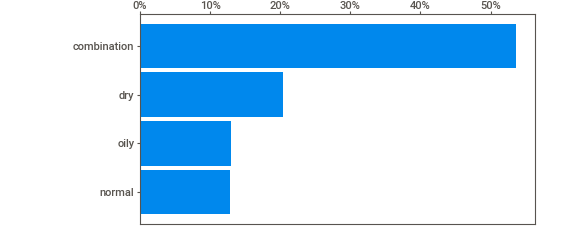
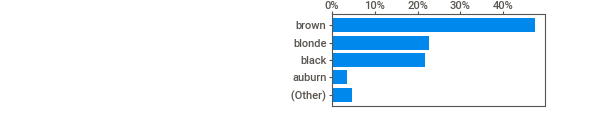
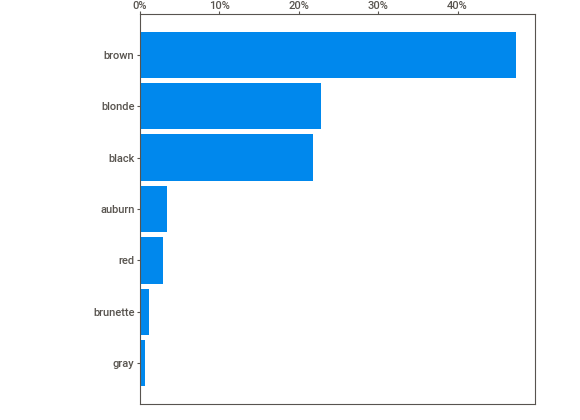
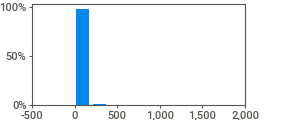
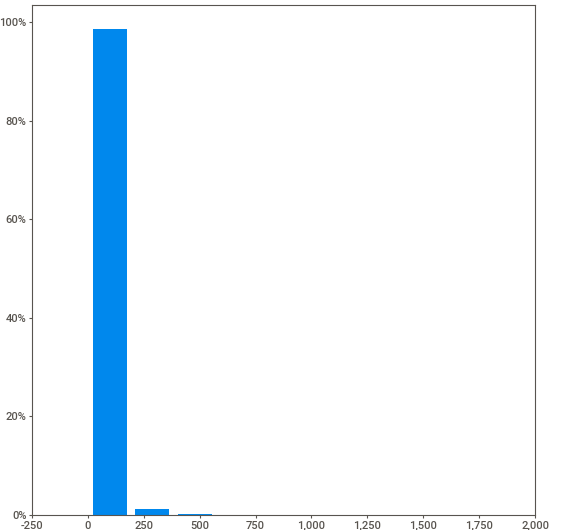
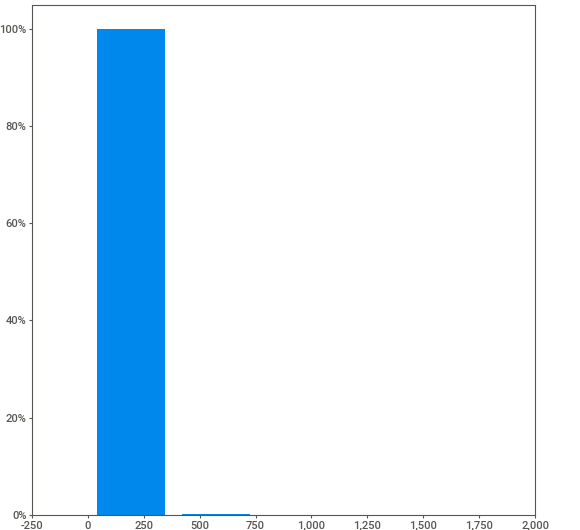
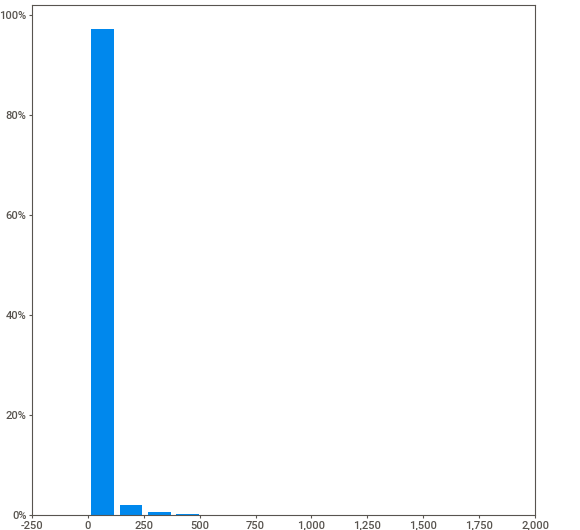
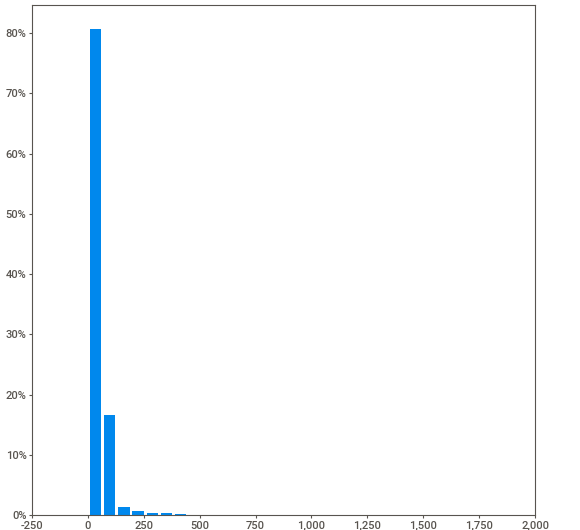
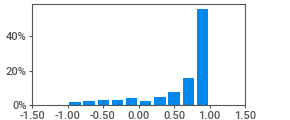
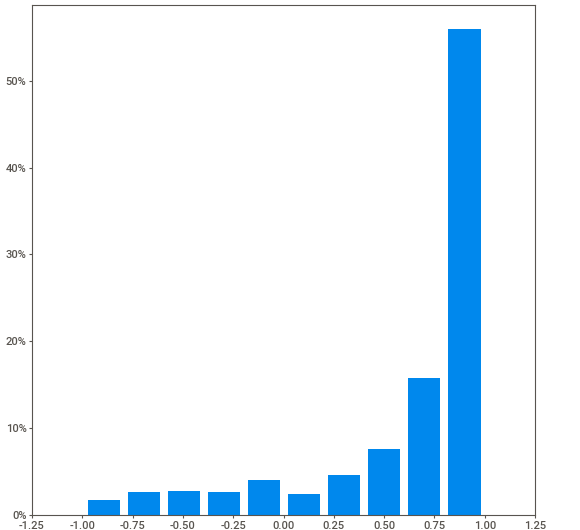
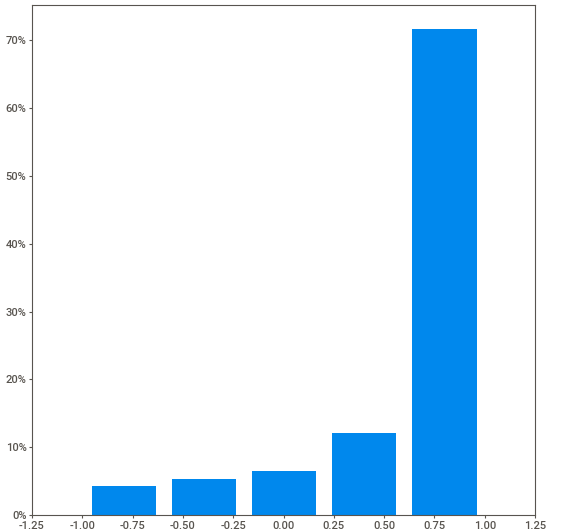
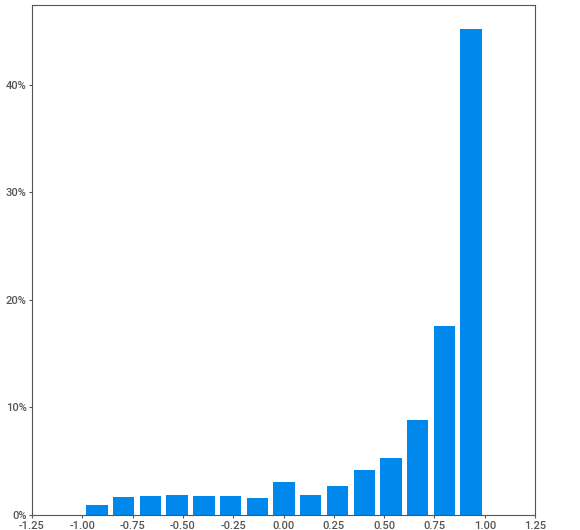
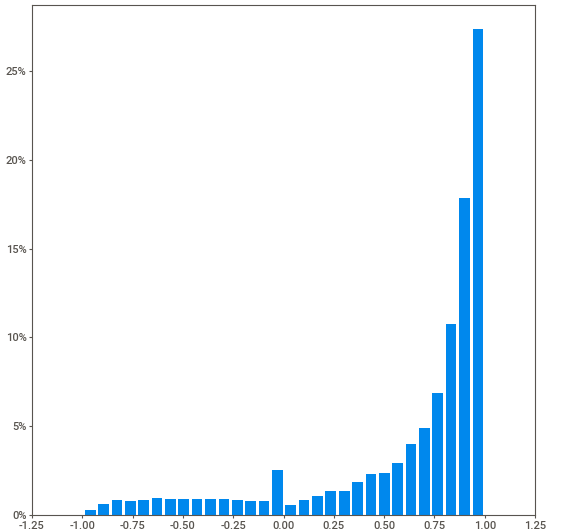
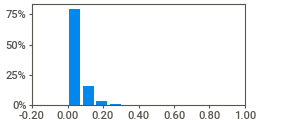
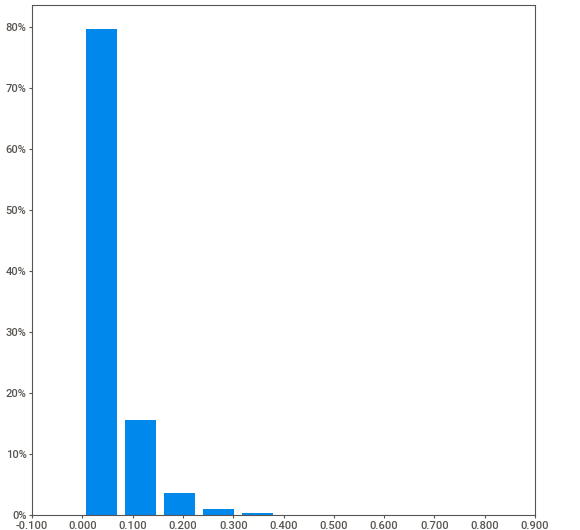
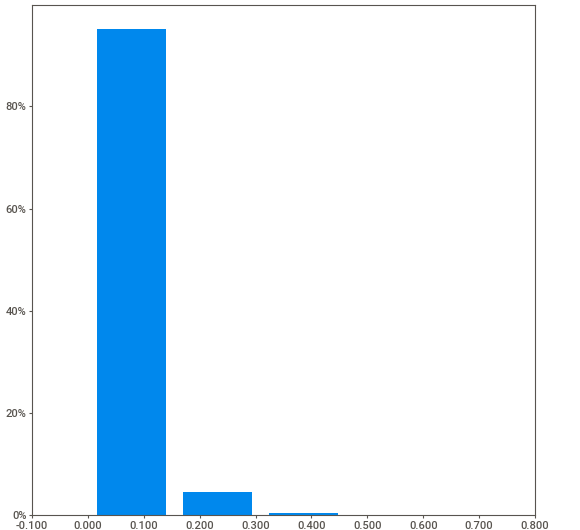
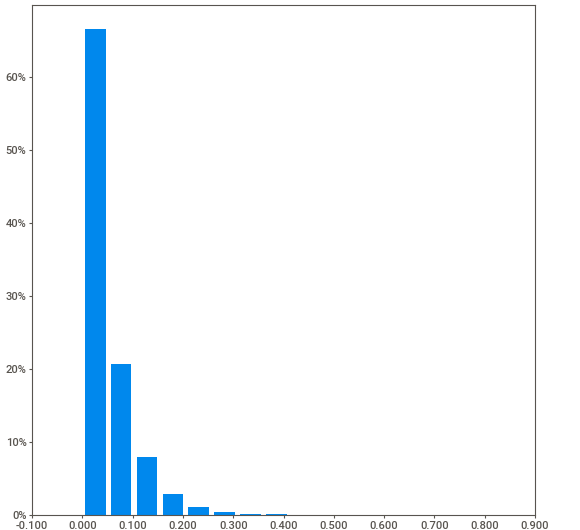
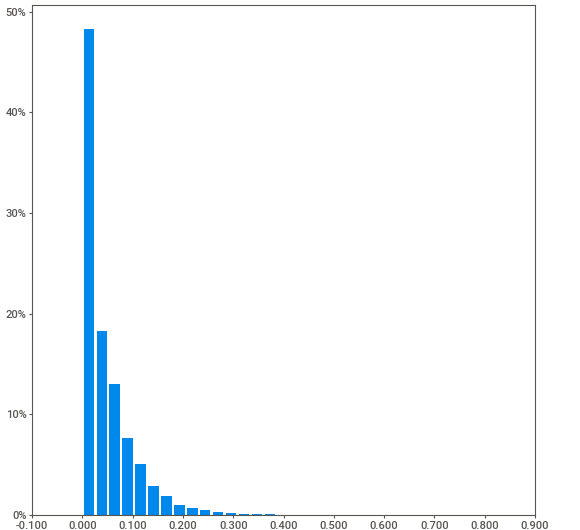
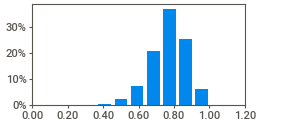
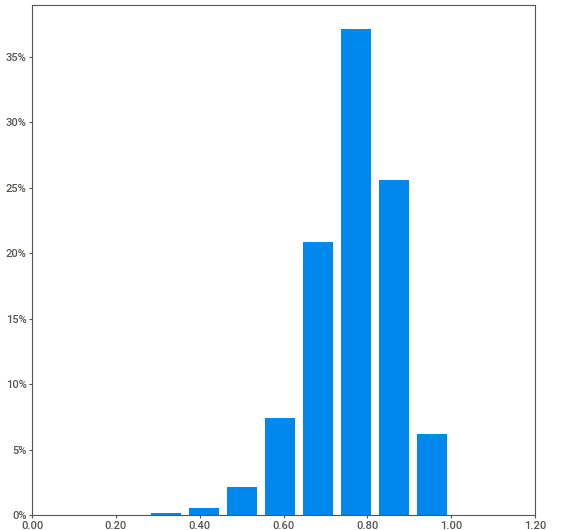
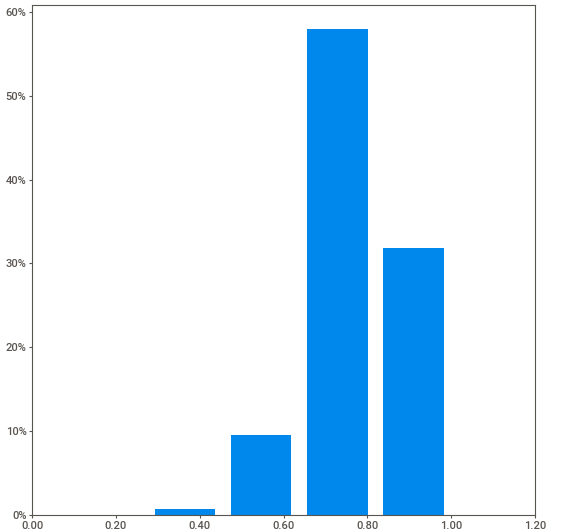
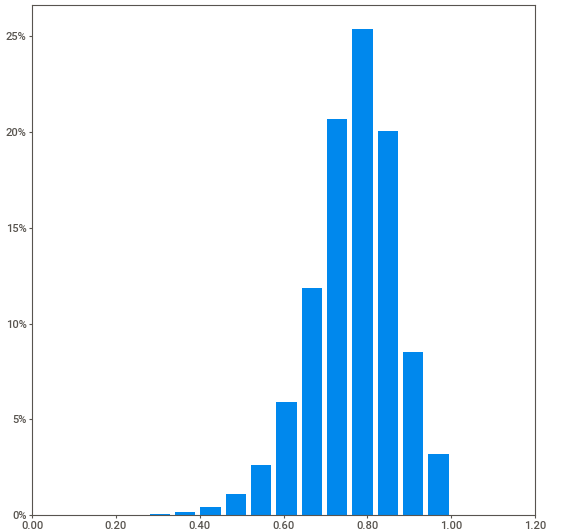
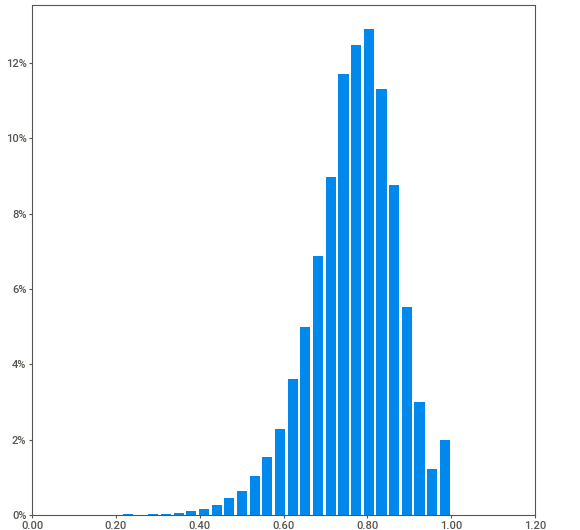
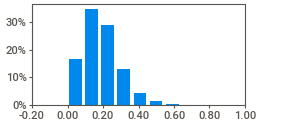
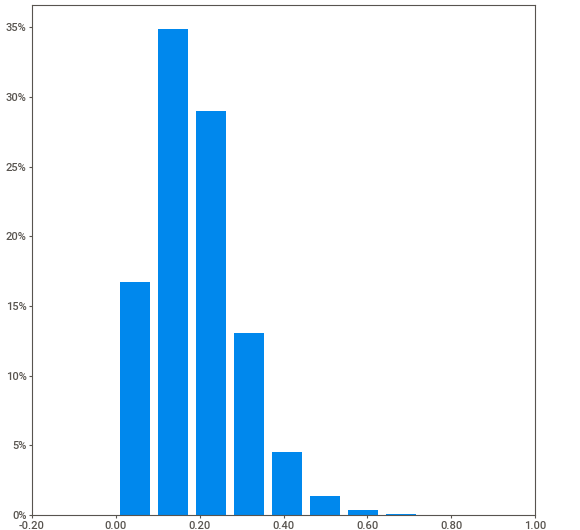
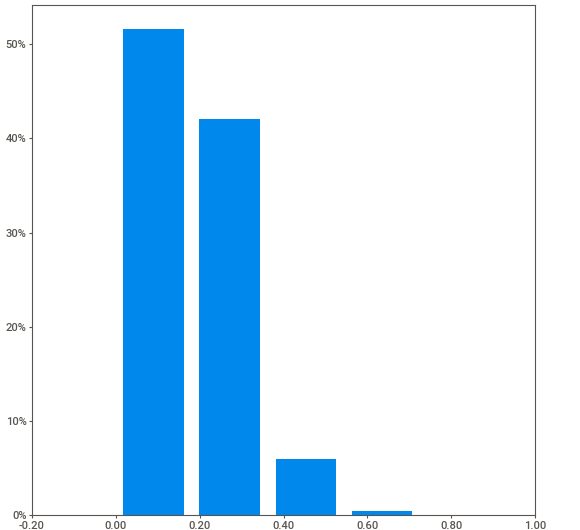
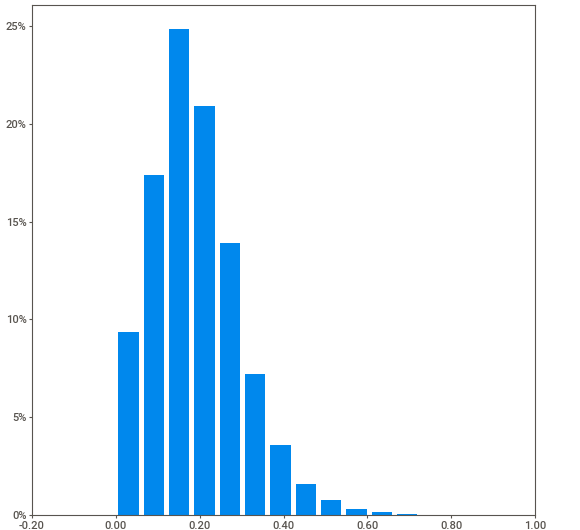
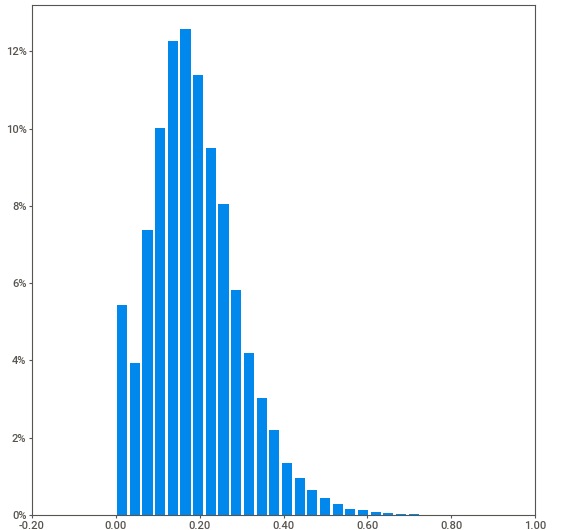
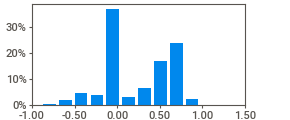
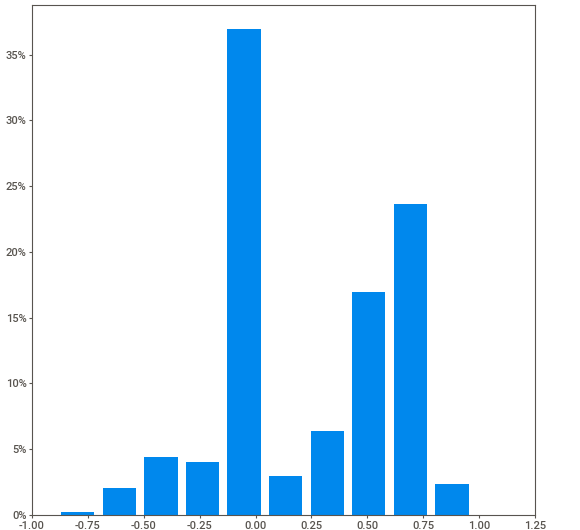
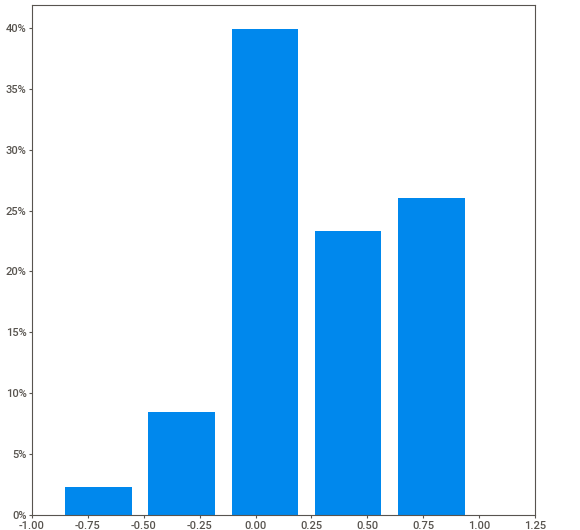
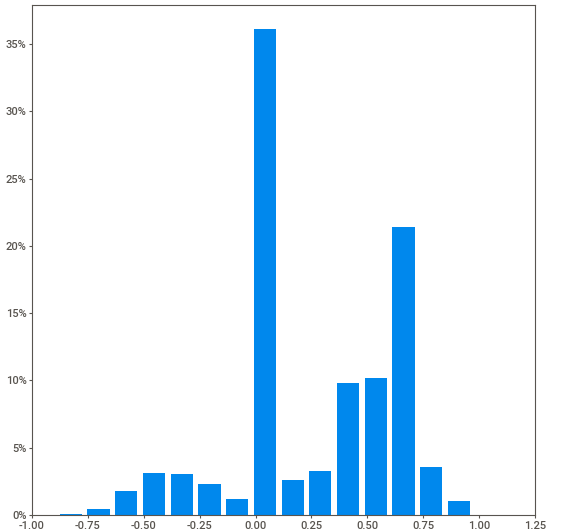
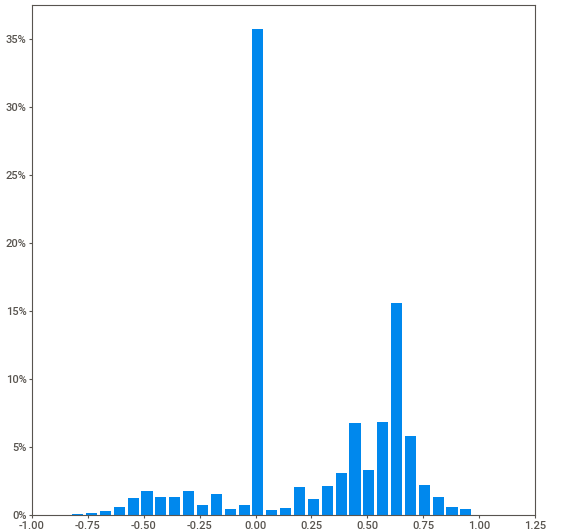
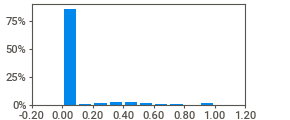
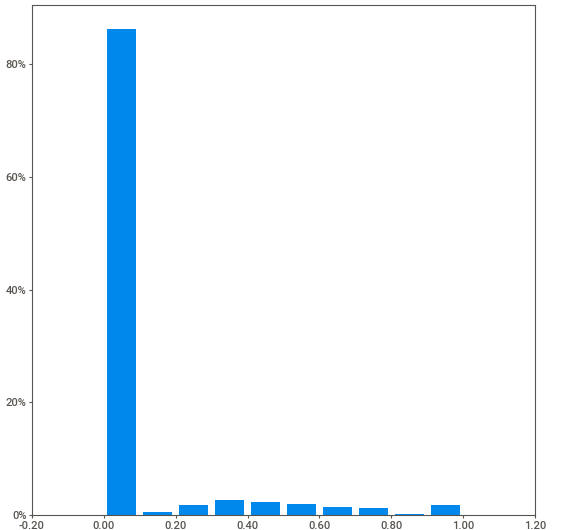
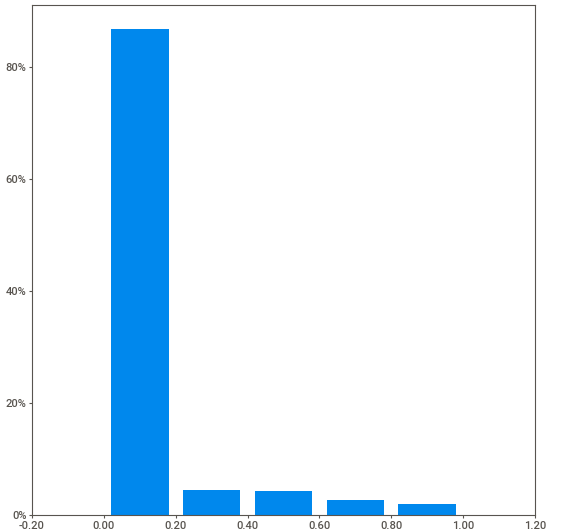
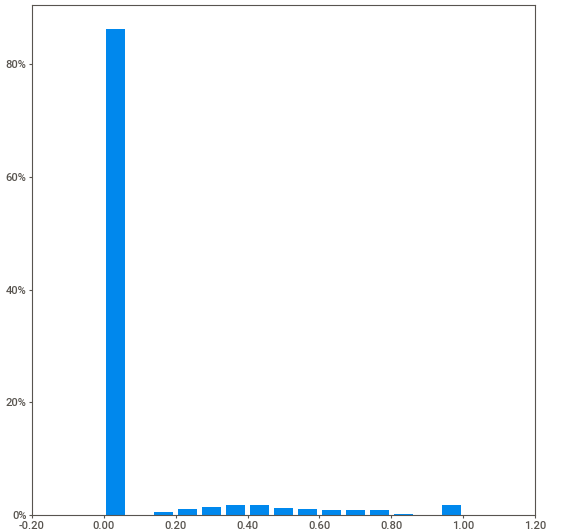
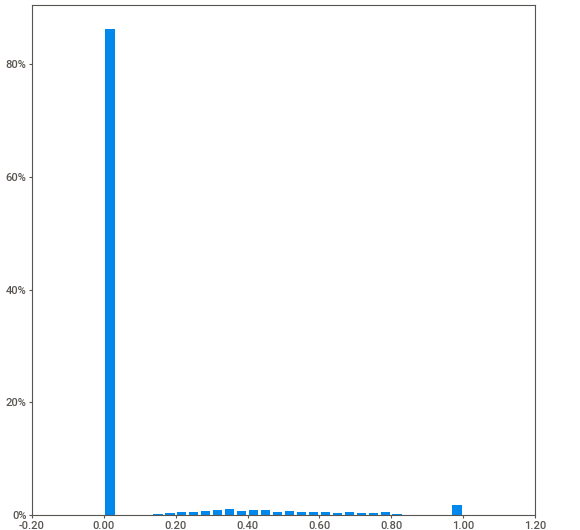
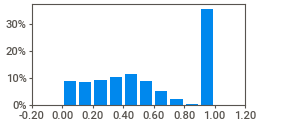
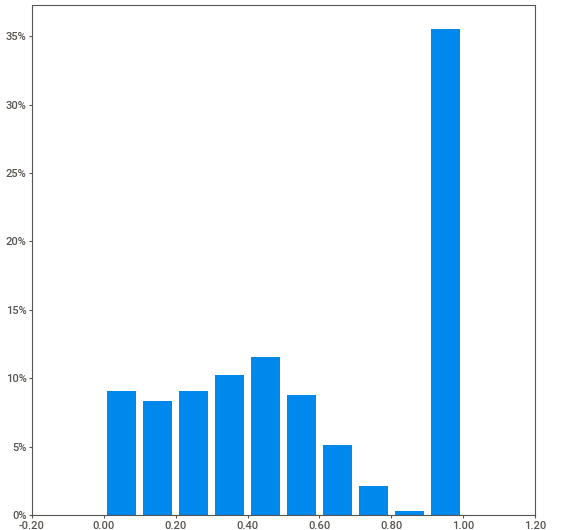
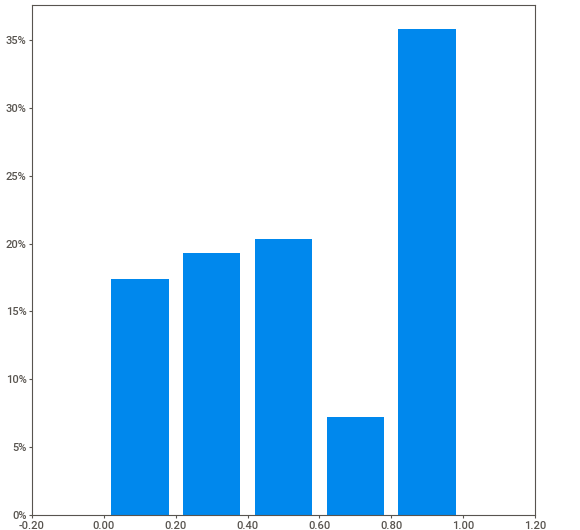
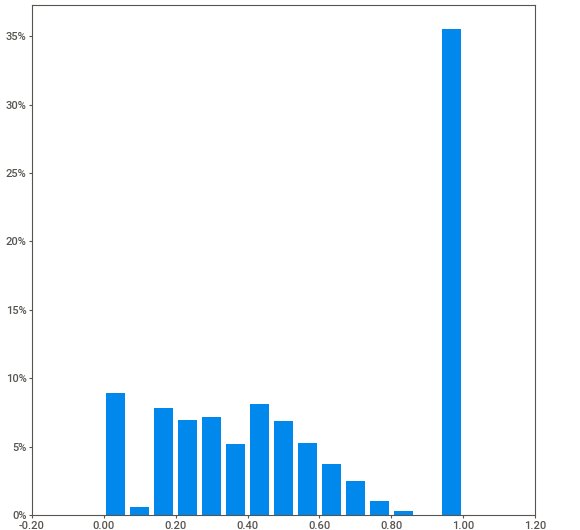
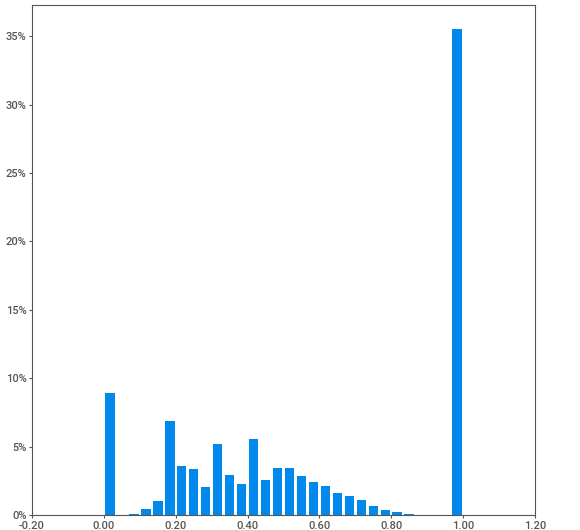
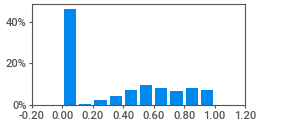
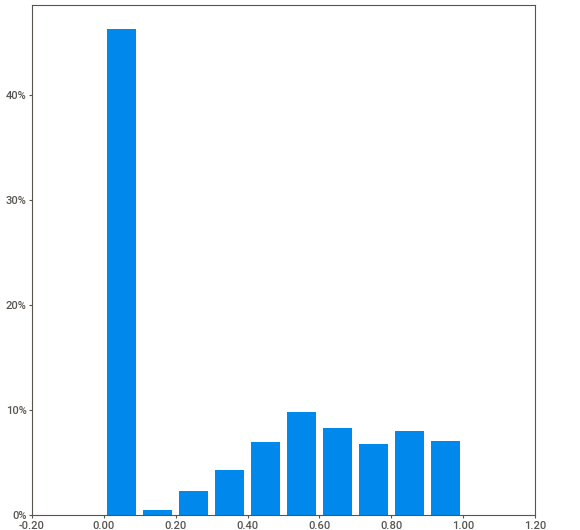
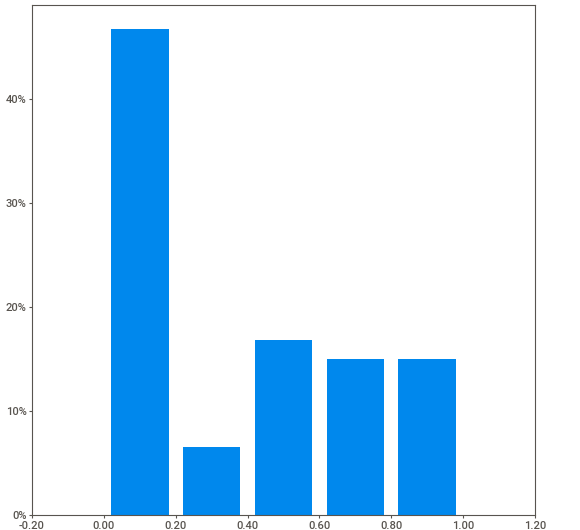
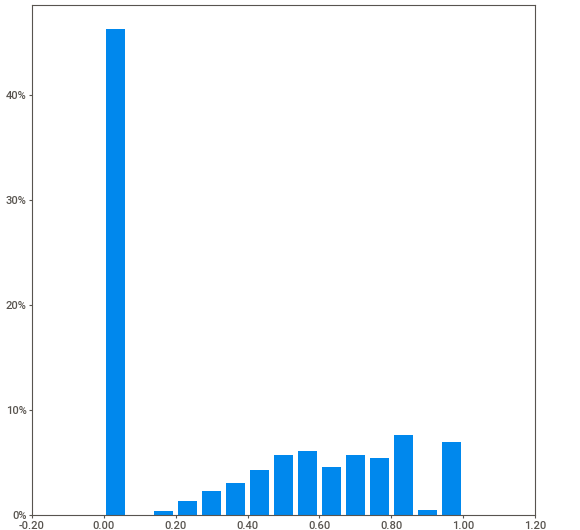
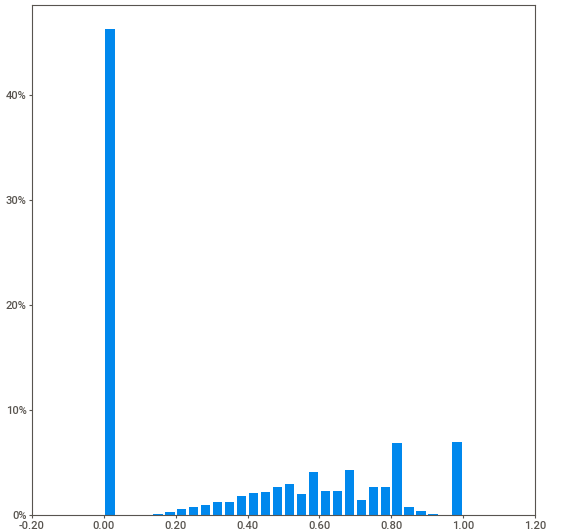
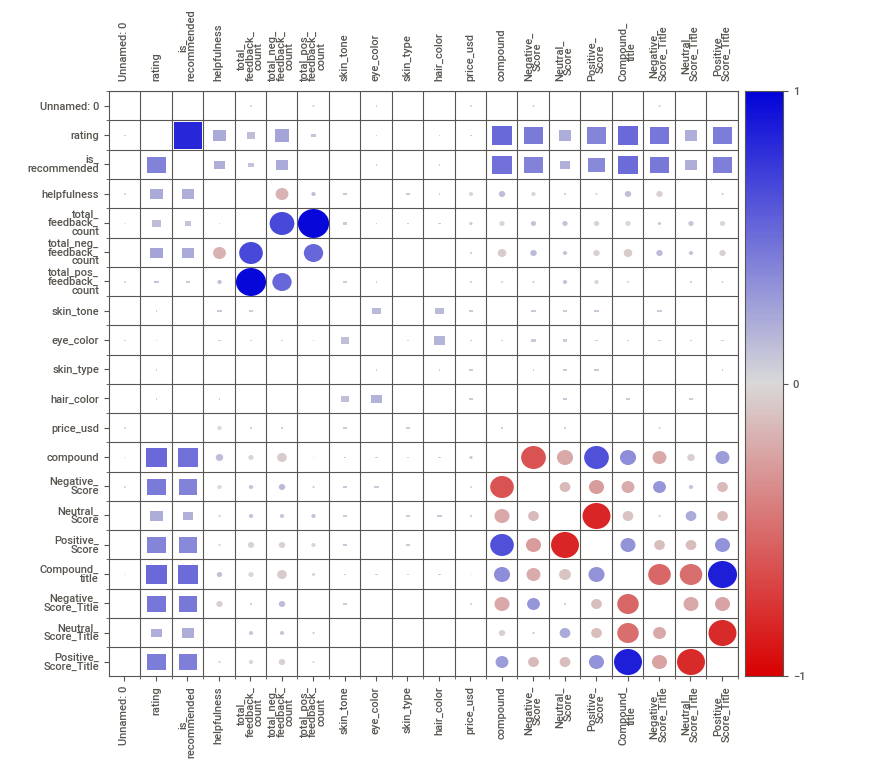
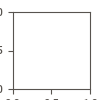

In [18]:
#Regenerate EDA report
report2 = sv.analyze(df)
report2.show_notebook()

In [19]:
#Correlations
df11 = df[['rating','helpfulness','total_feedback_count', 'total_neg_feedback_count','total_pos_feedback_count','price_usd','compound','Negative_Score','Neutral_Score',	'Positive_Score', 'Compound_title',	'Negative_Score_Title',	'Neutral_Score_Title',	'Positive_Score_Title']]
df11.corr(method= 'spearman')

rating  helpfulness  total_feedback_count  \
rating                    1.000000     0.220703             -0.193452   
helpfulness               0.220703     1.000000             -0.185384   
total_feedback_count     -0.193452    -0.185384              1.000000   
total_neg_feedback_count -0.284884    -0.861199              0.541245   
total_pos_feedback_count -0.109483     0.124984              0.926628   
price_usd                 0.010447    -0.051661             -0.016915   
compound                  0.388033     0.098663             -0.124902   
Negative_Score           -0.320684    -0.057617              0.175735   
Neutral_Score            -0.160380    -0.005537              0.142161   
Positive_Score            0.355957     0.057770             -0.223650   
Compound_title            0.438455     0.113743             -0.159333   
Negative_Score_Title     -0.398074    -0.109685              0.129234   
Neutral_Score_Title      -0.150835    -0.018754              0.101131   
Positive_Score_Title      0.355502     0.082421             -0.160947   

                          total_neg_feedback_count  total_pos_feedback_count  \
rating                                   -0.284884                 -0.109483   
helpfulness                              -0.861199                  0.124984   
total_feedback_count                      0.541245                  0.926628   
total_neg_feedback_count                  1.000000                  0.268489   
total_pos_feedback_count                  0.268489                  1.000000   
price_usd                                 0.044250                 -0.025424   
compound                                 -0.141180                 -0.083300   
Negative_Score                            0.127328                  0.151527   
Neutral_Score                             0.064272                  0.141893   
Positive_Score                           -0.146137                 -0.200971   
Compound_title                           -0.171086                 -0.114481   
Negative_Score_Title                      0.153284                  0.084019   
Neutral_Score_Title                       0.061473                  0.095559   
Positive_Score_Title                     -0.143593                 -0.128900   

                          price_usd  compound  Negative_Score  Neutral_Score  \
rating                     0.010447  0.388033       -0.320684      -0.160380   
helpfulness               -0.051661  0.098663       -0.057617      -0.005537   
total_feedback_count      -0.016915 -0.124902        0.175735       0.142161   
total_neg_feedback_count   0.044250 -0.141180        0.127328       0.064272   
total_pos_feedback_count  -0.025424 -0.083300        0.151527       0.141893   
price_usd                  1.000000  0.076184       -0.015305       0.011124   
compound                   0.076184  1.000000       -0.405493      -0.414817   
Negative_Score            -0.015305 -0.405493        1.000000      -0.129637   
Neutral_Score              0.011124 -0.414817       -0.129637       1.000000   
Positive_Score             0.006906  0.693746       -0.345829      -0.833889   
Compound_title            -0.005305  0.289389       -0.224969      -0.157924   
Negative_Score_Title       0.002436 -0.222014        0.244656       0.042140   
Neutral_Score_Title        0.006601 -0.104250        0.068043       0.173072   
Positive_Score_Title      -0.004643  0.231827       -0.191911      -0.184967   

                          Positive_Score  Compound_title  \
rating                          0.355957        0.438455   
helpfulness                     0.057770        0.113743   
total_feedback_count           -0.223650       -0.159333   
total_neg_feedback_count       -0.146137       -0.171086   
total_pos_feedback_count       -0.200971       -0.114481   
price_usd                       0.006906       -0.005305   
compound                        0.693746        0.289389   
Negative_Score                 -0.345829       -0.

In [20]:
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
cramers_corrected_stat(pd.crosstab(df['rating'],df['is_recommended']))

0.9173823174833285

In [21]:
cramers_corrected_stat(pd.crosstab(df['rating'],df['skin_type']))
cramers_corrected_stat(pd.crosstab(df['rating'],df['brand_name']))
cramers_corrected_stat(pd.crosstab(df['rating'],df['hair_color']))
cramers_corrected_stat(pd.crosstab(df['rating'],df['skin_tone']))
cramers_corrected_stat(pd.crosstab(df['rating'],df['eye_color']))

0.005424672322672878

In [22]:
#Creating new dataframe by undersampling to the length of the rating with the least number of reviews
df2=df[df['rating'] == 2]
df5=df[df['rating'] == 5].sample(len(df2),random_state=123)
df4=df[df['rating'] == 4].sample(len(df2),random_state=123)
df3=df[df['rating'] == 3].sample(len(df2),random_state=123)
df1=df[df['rating'] == 1].sample(len(df2),random_state=42)
mydfs = [df1,df2,df3,df4,df5]
df_uns = pd.concat(mydfs,axis=0)
df_uns.rating.value_counts()

1    7358
2    7358
3    7358
4    7358
5    7358
Name: rating, dtype: int64

In [23]:
#Creating dataframes for each approach
#Non textual attributes (normal and undersampled)
dfa = df[['rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'brand_name',  'price_usd']]
dfa2 = df_uns[['rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'brand_name',  'price_usd']]
#Vader calculated attributes (normal and undersampled)
dfb = df[['rating','compound','Negative_Score','Neutral_Score',	'Positive_Score', 'Compound_title',	'Negative_Score_Title',	'Neutral_Score_Title',	'Positive_Score_Title']]
dfb2 = df_uns[['rating','compound','Negative_Score','Neutral_Score',	'Positive_Score', 'Compound_title',	'Negative_Score_Title',	'Neutral_Score_Title',	'Positive_Score_Title']]
#Textual attributes (normal and undersampled)
dfc = df [['rating', 'review_text']]
dfc2 = df_uns[['rating', 'review_text']]

In [24]:
#Method A - Non-Textual Attributes:
#Creating instance of one-hot-encoder
encoder = OneHotEncoder()

#Perform one-hot encoding
encoder_df = pd.DataFrame(encoder.fit_transform(dfa[['skin_tone', 'eye_color', 'skin_type', 'hair_color', 'brand_name']]).toarray())
dfa = dfa.reset_index(drop=True)

#merge one-hot encoded columns back with original DataFrame
final_dfa = dfa.join(encoder_df, how="inner")

#view final df
final_dfa = final_dfa.drop(columns= ['skin_tone', 'eye_color', 'skin_type', 'hair_color', 'brand_name'])
final_dfa.columns = final_dfa.columns.astype(str)


In [25]:
#Normalizing numerical attributes
min_max_scaler = MinMaxScaler()
columnsa = ['total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'price_usd' ]
final_dfa[columnsa] = min_max_scaler.fit_transform(final_dfa[columnsa])

In [26]:
#Split data into train and test
ya= final_dfa.rating
xa= final_dfa.drop('rating', axis=1)

xa_train,xa_test,ya_train,ya_test=train_test_split(xa,ya,test_size=0.2,random_state=
123)


In [27]:
#Recursive feature selection, top 10 attributes
rfe_method = RFE(
    RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=10,
    step=2,
)
rfe_method.fit(xa_train, ya_train)

RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=10, step=2)

In [28]:
for i, col in zip(range(xa_train.shape[1]), xa_train.columns):
    print(f"{col} selected={rfe_method.support_[i]} rank={rfe_method.ranking_[i]}")

is_recommended selected=True rank=1
helpfulness selected=True rank=1
total_feedback_count selected=True rank=1
total_neg_feedback_count selected=True rank=1
total_pos_feedback_count selected=True rank=1
price_usd selected=True rank=1
0 selected=False rank=59
1 selected=False rank=18
2 selected=True rank=1
3 selected=False rank=8
4 selected=True rank=1
5 selected=False rank=3
6 selected=False rank=9
7 selected=False rank=6
8 selected=False rank=76
9 selected=False rank=58
10 selected=False rank=55
11 selected=False rank=30
12 selected=False rank=12
13 selected=False rank=31
14 selected=False rank=2
15 selected=False rank=2
16 selected=False rank=64
17 selected=False rank=7
18 selected=False rank=7
19 selected=True rank=1
20 selected=False rank=4
21 selected=False rank=4
22 selected=False rank=6
23 selected=False rank=15
24 selected=False rank=5
25 selected=False rank=3
26 selected=True rank=1
27 selected=False rank=28
28 selected=False rank=36
29 selected=False rank=13
30 selected=False

In [29]:
#Keep only top 10 attributes
xa_train = xa_train[['is_recommended','helpfulness','total_feedback_count','total_neg_feedback_count','total_pos_feedback_count','price_usd', '5','16','20','27']]
xa_test = xa_test[['is_recommended','helpfulness','total_feedback_count','total_neg_feedback_count','total_pos_feedback_count','price_usd', '5','16','20','27']]



In [30]:
#RandomForest Classifier
model = RandomForestClassifier()
model.fit(xa_train, ya_train)
ya_pred = model.predict(xa_test)

In [31]:
#Create dataframe with output and rating
preds_a = pd.DataFrame(ya_pred, columns=['pred_a'])
ya_test = ya_test.reset_index(drop=True)
ya_test = pd.DataFrame(ya_test, columns=['rating'])
resultsa = ya_test.join(preds_a , how="inner")
print(resultsa)

       rating  pred_a
0           5       5
1           5       5
2           5       5
3           5       5
4           5       5
...       ...     ...
19995       3       1
19996       1       2
19997       5       5
19998       1       1
19999       5       5

[20000 rows x 2 columns]


In [32]:
#Printing evaluation metrics
def evaluation_parametrics(namea, ya_test, ya_pred):
    cma = confusion_matrix(ya_test, ya_pred)
    t1a = ConfusionMatrixDisplay(cma)
    print("Classification Report for Random Forest Classifier: \n")
    print(classification_report(ya_test, ya_pred))
    t1a.plot()

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           1       0.49      0.55      0.52      2071
           2       0.29      0.27      0.28      1464
           3       0.23      0.16      0.19      1766
           4       0.19      0.06      0.09      2769
           5       0.79      0.94      0.86     11930

    accuracy                           0.66     20000
   macro avg       0.40      0.40      0.39     20000
weighted avg       0.59      0.66      0.61     20000



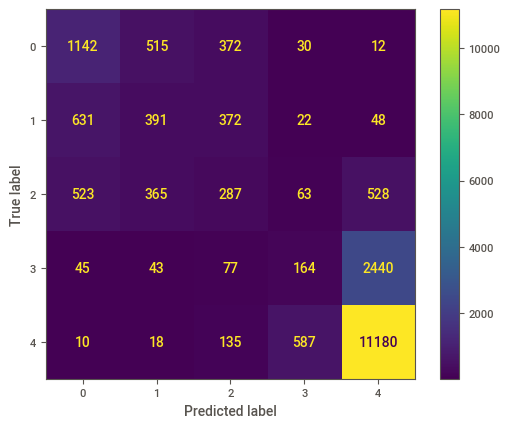

In [33]:
evaluation_parametrics('Machine Learning Classification', ya_test, ya_pred)

In [34]:
#Method A - Undersampling

#creating instance of one-hot-encoder
encoder2 = OneHotEncoder()

#perform one-hot encoding
encoder_df2 = pd.DataFrame(encoder2.fit_transform(dfa2[['skin_tone', 'eye_color', 'skin_type', 'hair_color', 'brand_name']]).toarray())
dfa2 = dfa2.reset_index(drop=True)

#merge one-hot encoded columns back with original DataFrame
final_dfa2 = dfa2.join(encoder_df2, how="inner")

#view final df
final_dfa2 = final_dfa2.drop(columns= ['skin_tone', 'eye_color', 'skin_type', 'hair_color', 'brand_name'])
final_dfa2.columns = final_dfa2.columns.astype(str)


In [35]:
#Normalizing numerical attributes
min_max_scaler = MinMaxScaler()
columnsa2 = ['total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'price_usd' ]
final_dfa2[columnsa2] = min_max_scaler.fit_transform(final_dfa2[columnsa2])

In [36]:
#Split data into training and testing
ya2= final_dfa2.rating
xa2= final_dfa2.drop('rating', axis=1)

xa_train2,xa_test2,ya_train2,ya_test2=train_test_split(xa2,ya2,test_size=0.2,random_state=
123)


In [37]:
#Recursive feature selection on the undersampled dataset. Keep top 10 attributes.
rfe_method = RFE(
    RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=10,
    step=2,
)

rfe_method.fit(xa_train2, ya_train2)

for i, col in zip(range(xa_train2.shape[1]), xa_train2.columns):
    print(f"{col} selected={rfe_method.support_[i]} rank={rfe_method.ranking_[i]}")

is_recommended selected=True rank=1
helpfulness selected=True rank=1
total_feedback_count selected=True rank=1
total_neg_feedback_count selected=True rank=1
total_pos_feedback_count selected=True rank=1
price_usd selected=True rank=1
0 selected=False rank=65
1 selected=False rank=19
2 selected=False rank=2
3 selected=False rank=9
4 selected=True rank=1
5 selected=False rank=4
6 selected=False rank=7
7 selected=False rank=8
8 selected=False rank=83
9 selected=False rank=56
10 selected=False rank=56
11 selected=False rank=30
12 selected=False rank=13
13 selected=False rank=36
14 selected=False rank=4
15 selected=True rank=1
16 selected=False rank=68
17 selected=False rank=6
18 selected=False rank=6
19 selected=True rank=1
20 selected=False rank=3
21 selected=False rank=5
22 selected=False rank=8
23 selected=False rank=11
24 selected=False rank=5
25 selected=False rank=3
26 selected=True rank=1
27 selected=False rank=30
28 selected=False rank=38
29 selected=False rank=15
30 selected=False

In [38]:
#Keep only top 10 attributes
xa_train2 = xa_train2[['is_recommended','helpfulness','total_feedback_count','total_neg_feedback_count','total_pos_feedback_count','price_usd', '3','16','20','27']]
xa_test2 = xa_test2[['is_recommended','helpfulness','total_feedback_count','total_neg_feedback_count','total_pos_feedback_count','price_usd', '3','16','20','27']]


In [39]:
#Random forest classifier
model2 = RandomForestClassifier()
model2.fit(xa_train2, ya_train2)
ya_pred2 = model2.predict(xa_test2)

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           1       0.45      0.46      0.45      1429
           2       0.36      0.40      0.38      1400
           3       0.29      0.22      0.25      1525
           4       0.40      0.42      0.41      1479
           5       0.45      0.49      0.47      1525

    accuracy                           0.40      7358
   macro avg       0.39      0.40      0.39      7358
weighted avg       0.39      0.40      0.39      7358



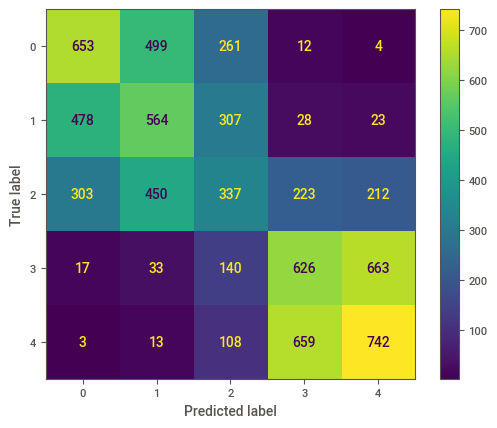

In [40]:
#Printing evaluation metrics. We can see here that the overall accuracy is reduced by undersampling.

def evaluation_parametrics(namea2, ya_test2, ya_pred2):
    cma2 = confusion_matrix(ya_test2, ya_pred2)
    t1a2 = ConfusionMatrixDisplay(cma2)
    print("Classification Report for Random Forest Classifier: \n")
    print(classification_report(ya_test2, ya_pred2))
    t1a2.plot()

evaluation_parametrics('Machine Learning Classification', ya_test2, ya_pred2)

In [41]:
#Method B - VADER Calculated Sentiment
#Splitting the data into training and testing ensuring the same random state as other methods.
yb= dfb.rating
xb= dfb.drop('rating', axis=1)

xb_train,xb_test,yb_train,yb_test=train_test_split(xb,yb,test_size=0.2,random_state=
123)


In [42]:
#Random forest classifier
model3 = RandomForestClassifier()
model3.fit(xb_train, yb_train)
yb_pred = model3.predict(xb_test)

In [43]:
#Create dataframe with output and rating
preds_b = pd.DataFrame(yb_pred, columns=['pred_b'])
yb_test = yb_test.reset_index(drop=True)
yb_test = pd.DataFrame(yb_test, columns=['rating'])
resultsb = yb_test.join(preds_b , how="inner")

In [44]:
#Printing evaluation metrics. We can see here that the overall accuracy is very close to Method A.
def evaluation_parametrics(nameb, yb_test, yb_pred):
    cmb = confusion_matrix(yb_test, yb_pred)
    t1b = ConfusionMatrixDisplay(cmb)
    print("Classification Report for Random Forest Classifier: \n")
    print(classification_report(yb_test, yb_pred))
    t1b.plot()

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           1       0.48      0.51      0.49      2071
           2       0.32      0.19      0.24      1464
           3       0.33      0.20      0.25      1766
           4       0.33      0.14      0.20      2769
           5       0.72      0.88      0.79     11930

    accuracy                           0.63     20000
   macro avg       0.44      0.39      0.40     20000
weighted avg       0.58      0.63      0.59     20000



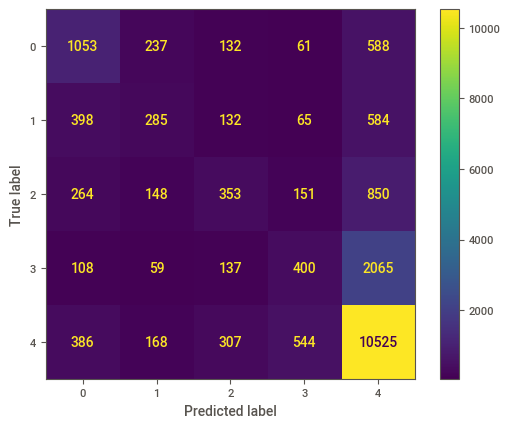

In [45]:
evaluation_parametrics('Machine Learning Classification', yb_test, yb_pred)

In [46]:
#Method B - Undersampling

#Splitting the dataset into training and testing.
yb2= dfb2.rating
xb2= dfb2.drop('rating', axis=1)

xb_train2,xb_test2,yb_train2,yb_test2=train_test_split(xb2,yb2,test_size=0.2,random_state=
123)


In [47]:
#Random Forest Classifier
model4 = RandomForestClassifier()
model4.fit(xb_train2, yb_train2)
yb_pred2 = model4.predict(xb_test2)

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           1       0.46      0.54      0.49      1429
           2       0.33      0.33      0.33      1400
           3       0.38      0.34      0.36      1525
           4       0.38      0.38      0.38      1479
           5       0.46      0.45      0.46      1525

    accuracy                           0.41      7358
   macro avg       0.40      0.41      0.40      7358
weighted avg       0.40      0.41      0.40      7358



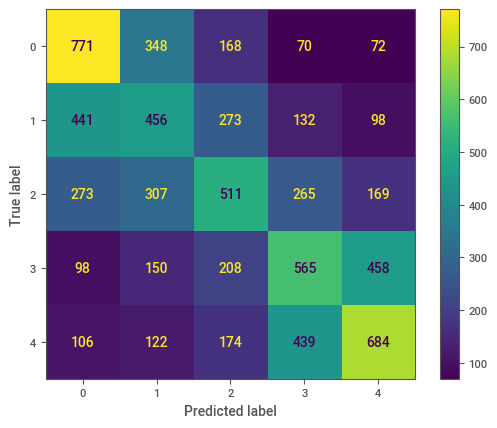

In [48]:
#Printing evaluation metrics. We can see here that the overall accuracy is reduced by undersampling.
def evaluation_parametrics(nameb2, yb_test2, yb_pred2):
    cmb2 = confusion_matrix(yb_test2, yb_pred2)
    t1b2 = ConfusionMatrixDisplay(cmb2)
    print("Classification Report for Random Forest Classifier: \n")
    print(classification_report(yb_test2, yb_pred2))
    t1b2.plot()

evaluation_parametrics('Machine Learning Classification', yb_test2, yb_pred2)

In [49]:
#Method C - Textual Attributes

#Preprocessing
def preprocess_text(text, remove_digits=True):
    # Removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Removing square brackets
    text = re.sub('\[[^]]*\]', '', text)

    # Removing special characters
    if remove_digits:
        text = re.sub('[^a-zA-Z\s]', '', text)
    else:
        text = re.sub('[^a-zA-Z0-9\s]', '', text)

    # Lowercasing
    text = text.lower()

    # Stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])

    # Removing stopwords
    stopword_list = set(stopwords.words('english'))
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [50]:
dfc['review_text'] = dfc['review_text'].apply(preprocess_text)

In [51]:
#Vectorizing and splitting the data into training and testing, ensuring the same random state as Method A and B.
yc= dfc.rating
xc= dfc.review_text

vec = TfidfVectorizer(analyzer = 'word', ngram_range=(2,2), max_features=500)
xc = vec.fit_transform(xc).toarray()


In [52]:
xc_train,xc_test,yc_train,yc_test=train_test_split(xc,yc,test_size=0.2,random_state=
123)

In [53]:
#Random Forest Classifier
model5 = RandomForestClassifier()
model5.fit(xc_train, yc_train)
yc_pred = model5.predict(xc_test)

In [54]:
#Create dataframe with output and rating
preds_c = pd.DataFrame(yc_pred, columns=['pred_c'])
yc_test = yc_test.reset_index(drop=True)
yc_test = pd.DataFrame(yc_test, columns=['rating'])
resultsc = yc_test.join(preds_c , how="inner")

In [55]:
#Printing evaluation metrics. We can see here that the overall accuracy is very close to Method A and B.
def evaluation_parametrics(namec, yc_test, yc_pred):
    cmc = confusion_matrix(yc_test, yc_pred)
    t1c = ConfusionMatrixDisplay(cmc)
    print("Classification Report for Random Forest Classifier: \n")
    print(classification_report(yc_test, yc_pred))
    t1c.plot()

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           1       0.44      0.31      0.37      2071
           2       0.41      0.14      0.21      1464
           3       0.39      0.15      0.22      1766
           4       0.51      0.15      0.23      2769
           5       0.69      0.95      0.80     11930

    accuracy                           0.64     20000
   macro avg       0.49      0.34      0.36     20000
weighted avg       0.59      0.64      0.58     20000



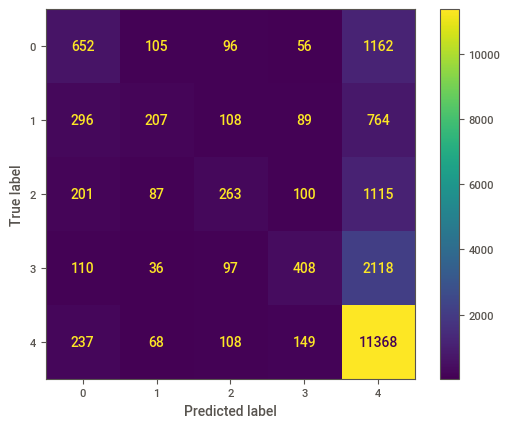

In [56]:
evaluation_parametrics('Machine Learning Classification', yc_test, yc_pred)

In [57]:
#Method C - Undersampling
#Apply preprocessing
dfc2['review_text'] = dfc2['review_text'].apply(preprocess_text)

In [58]:
#Vectorizing and splitting the data into training and testing.
yc2= dfc2.rating
xc2= dfc2.review_text

vec2 = TfidfVectorizer(analyzer = 'word', ngram_range=(2,2), max_features=500)
xc2 = vec.fit_transform(xc2).toarray()


In [59]:
xc_train2,xc_test2,yc_train2,yc_test2=train_test_split(xc2,yc2,test_size=0.2,random_state=
123)

In [60]:
#Random forest classifier
model6 = RandomForestClassifier()
model6.fit(xc_train2, yc_train2)
yc_pred2 = model6.predict(xc_test2)


In [61]:
#Printing evaluation metrics. We can see here that the overall accuracy is reduced by undersampling.
def evaluation_parametrics(namec2, yc_test2, yc_pred2):
    cmc2 = confusion_matrix(yc_test2, yc_pred2)
    t1c2 = ConfusionMatrixDisplay(cmc2)
    print("Classification Report for Random Forest Classifier: \n")
    print(classification_report(yc_test2, yc_pred2))
    t1c2.plot()

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           1       0.39      0.52      0.45      1429
           2       0.33      0.28      0.30      1400
           3       0.37      0.29      0.32      1525
           4       0.39      0.36      0.37      1479
           5       0.47      0.54      0.51      1525

    accuracy                           0.40      7358
   macro avg       0.39      0.40      0.39      7358
weighted avg       0.39      0.40      0.39      7358



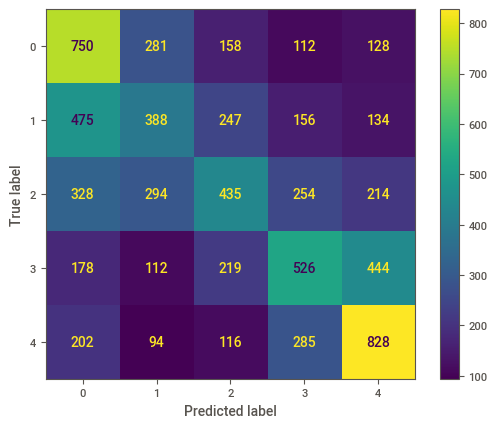

In [62]:
evaluation_parametrics('Machine Learning Classification', yc_test2, yc_pred2)

In [63]:
#Method 4 - The Hybrid Model

#Combining output of Method A, B & C into a datatable with rating.
Dfabc =[resultsa,resultsb,resultsc]
df_resultsall = pd.concat(Dfabc,axis=1)
df_abc = df_resultsall.loc[:,~df_resultsall.columns.duplicated()].copy()
print(df_abc)

       rating  pred_a  pred_b  pred_c
0           5       5       5       5
1           5       5       4       5
2           5       5       1       2
3           5       5       5       5
4           5       5       5       5
...       ...     ...     ...     ...
19995       3       1       2       5
19996       1       2       5       1
19997       5       5       5       5
19998       1       1       1       5
19999       5       5       5       5

[20000 rows x 4 columns]


In [64]:
#Splitting the dataset into training and testing
yabc= df_abc.rating
xabc= df_abc.drop('rating', axis=1)

xabc_train,xabc_test,yabc_train,yabc_test=train_test_split(xabc,yabc,test_size=0.2,random_state=
123)

In [65]:
#RandomForest Classifier
model7 = RandomForestClassifier()
model7.fit(xabc_train, yabc_train)
yabc_pred = model7.predict(xabc_test)

In [66]:
#Printing evaluation metrics. We can see here that the overall accuracy is improved above Methods A,B & C individually.
def evaluation_parametrics(nameabc, yabc_test, yabc_pred):
    cmabc = confusion_matrix(yabc_test, yabc_pred)
    t4 = ConfusionMatrixDisplay(cmabc)
    print("Classification Report for Random Forest Classifier: \n")
    print(classification_report(yabc_test, yabc_pred))
    t4.plot()

Classification Report for Random Forest Classifier: 

              precision    recall  f1-score   support

           1       0.51      0.82      0.63       422
           2       0.52      0.20      0.29       292
           3       0.47      0.20      0.28       347
           4       0.69      0.14      0.23       517
           5       0.80      0.98      0.89      2422

    accuracy                           0.73      4000
   macro avg       0.60      0.47      0.46      4000
weighted avg       0.71      0.73      0.68      4000



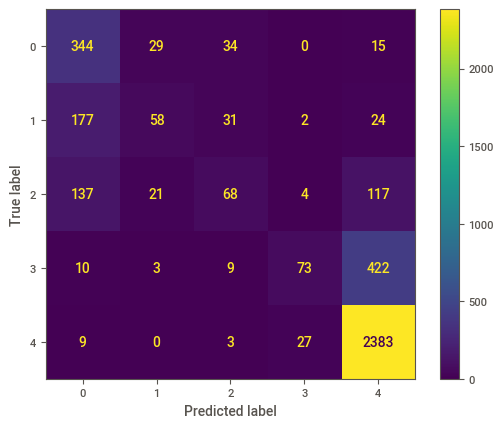

In [67]:
evaluation_parametrics('Machine Learning Classification', yabc_test, yabc_pred)